In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.2.1.dev0
scipy version: 1.3.1


In [3]:
import json

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u

import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

In [4]:
# Stellar parameters
with open(base_dir + "mass_radius.json", "r") as f:
    data = json.load(f)
    mass_radius_mu = np.array(data["mean"])
    mass_radius_cov = np.array(data["cov"])

In [13]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

23

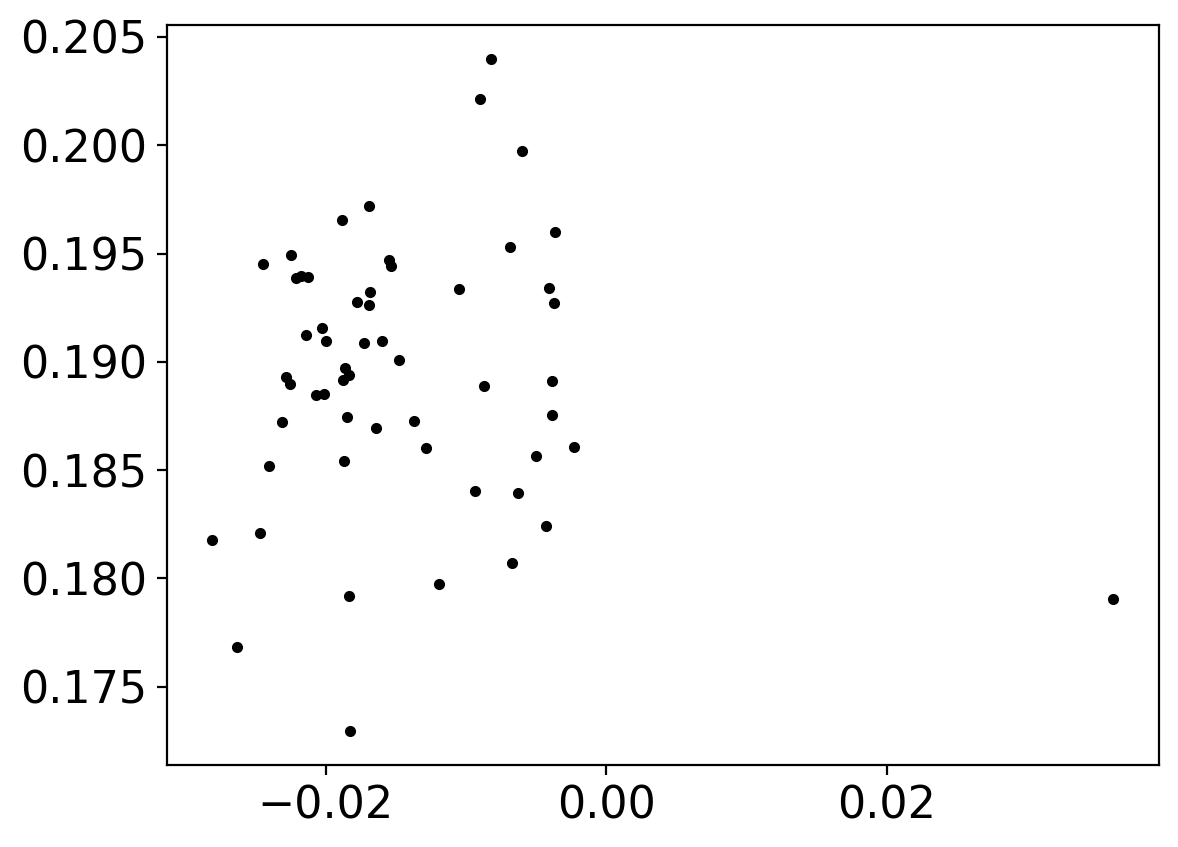

In [6]:
plt.plot(df.bis, df.s_hk, 'k.')
np.argmax(df.bis)

In [7]:
np.percentile(df.snr, [16,50,84])

array([ 74.62, 107.8 , 135.3 ])

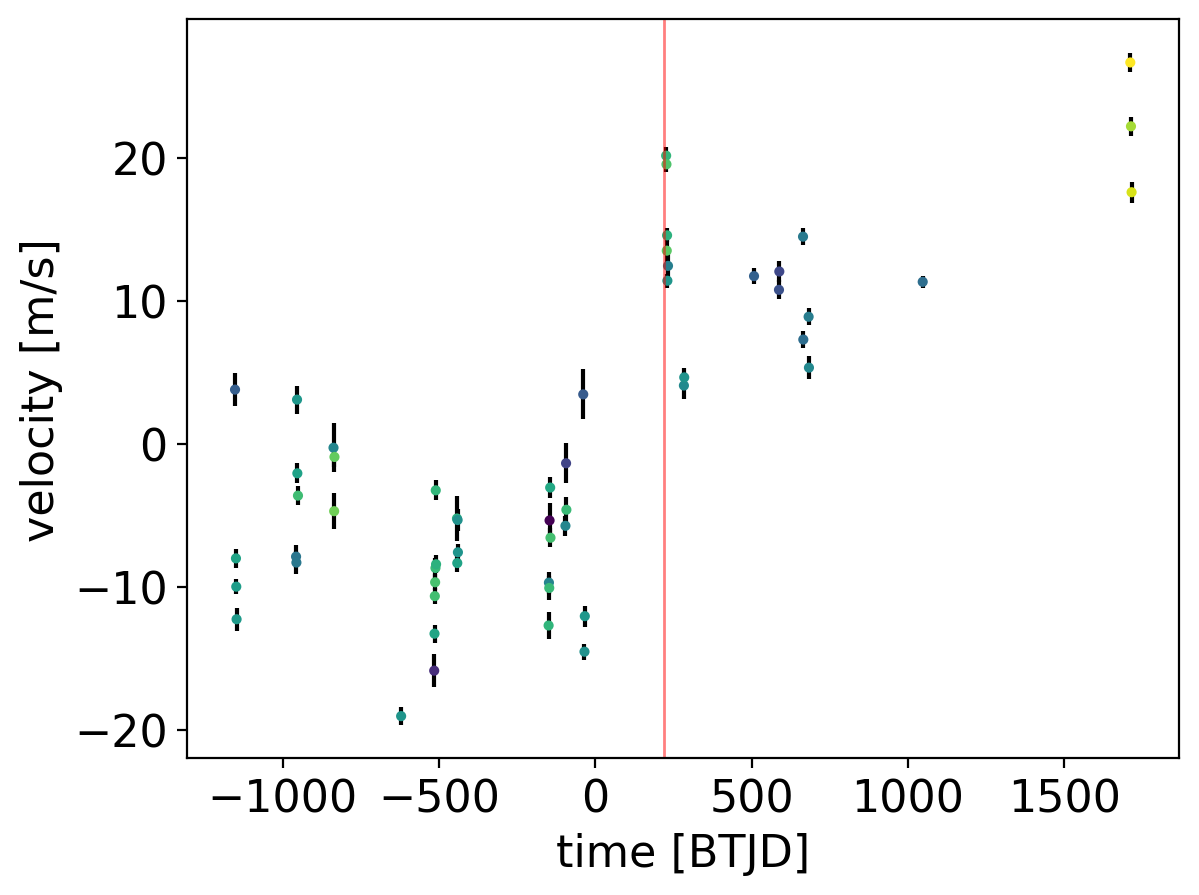

In [8]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

x_rv = np.ascontiguousarray(df.bjd - BTJD_ref, dtype=np.float64)
HARPS_upgrade -= BTJD_ref
pug = np.ascontiguousarray(x_rv >= HARPS_upgrade, dtype=bool) # stands for post-upgrade, obviously
y_rv = np.ascontiguousarray(df.rv - df.rv.mean(), dtype=np.float64)
yerr_rv = np.ascontiguousarray(df.e_rv, dtype=np.float64)
#bis_rv = np.ascontiguousarray((df.bis - df.bis.mean()) / df.bis.std(), dtype=np.float64)
#fwhm_rv = np.ascontiguousarray((df.fwhm - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
bis_rv = np.ascontiguousarray(df.bis, dtype=np.float64)
fwhm_rv = np.ascontiguousarray(df.fwhm, dtype=np.float64)
shk = np.ascontiguousarray(df.s_hk, dtype=np.float64)
yerr_shk = np.ascontiguousarray(df.e_s_hk, dtype=np.float64)



t = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
plt.scatter(x_rv, y_rv, c=shk, s=7)
plt.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
plt.xlabel("time [BTJD]")
plt.ylabel("velocity [m/s]");

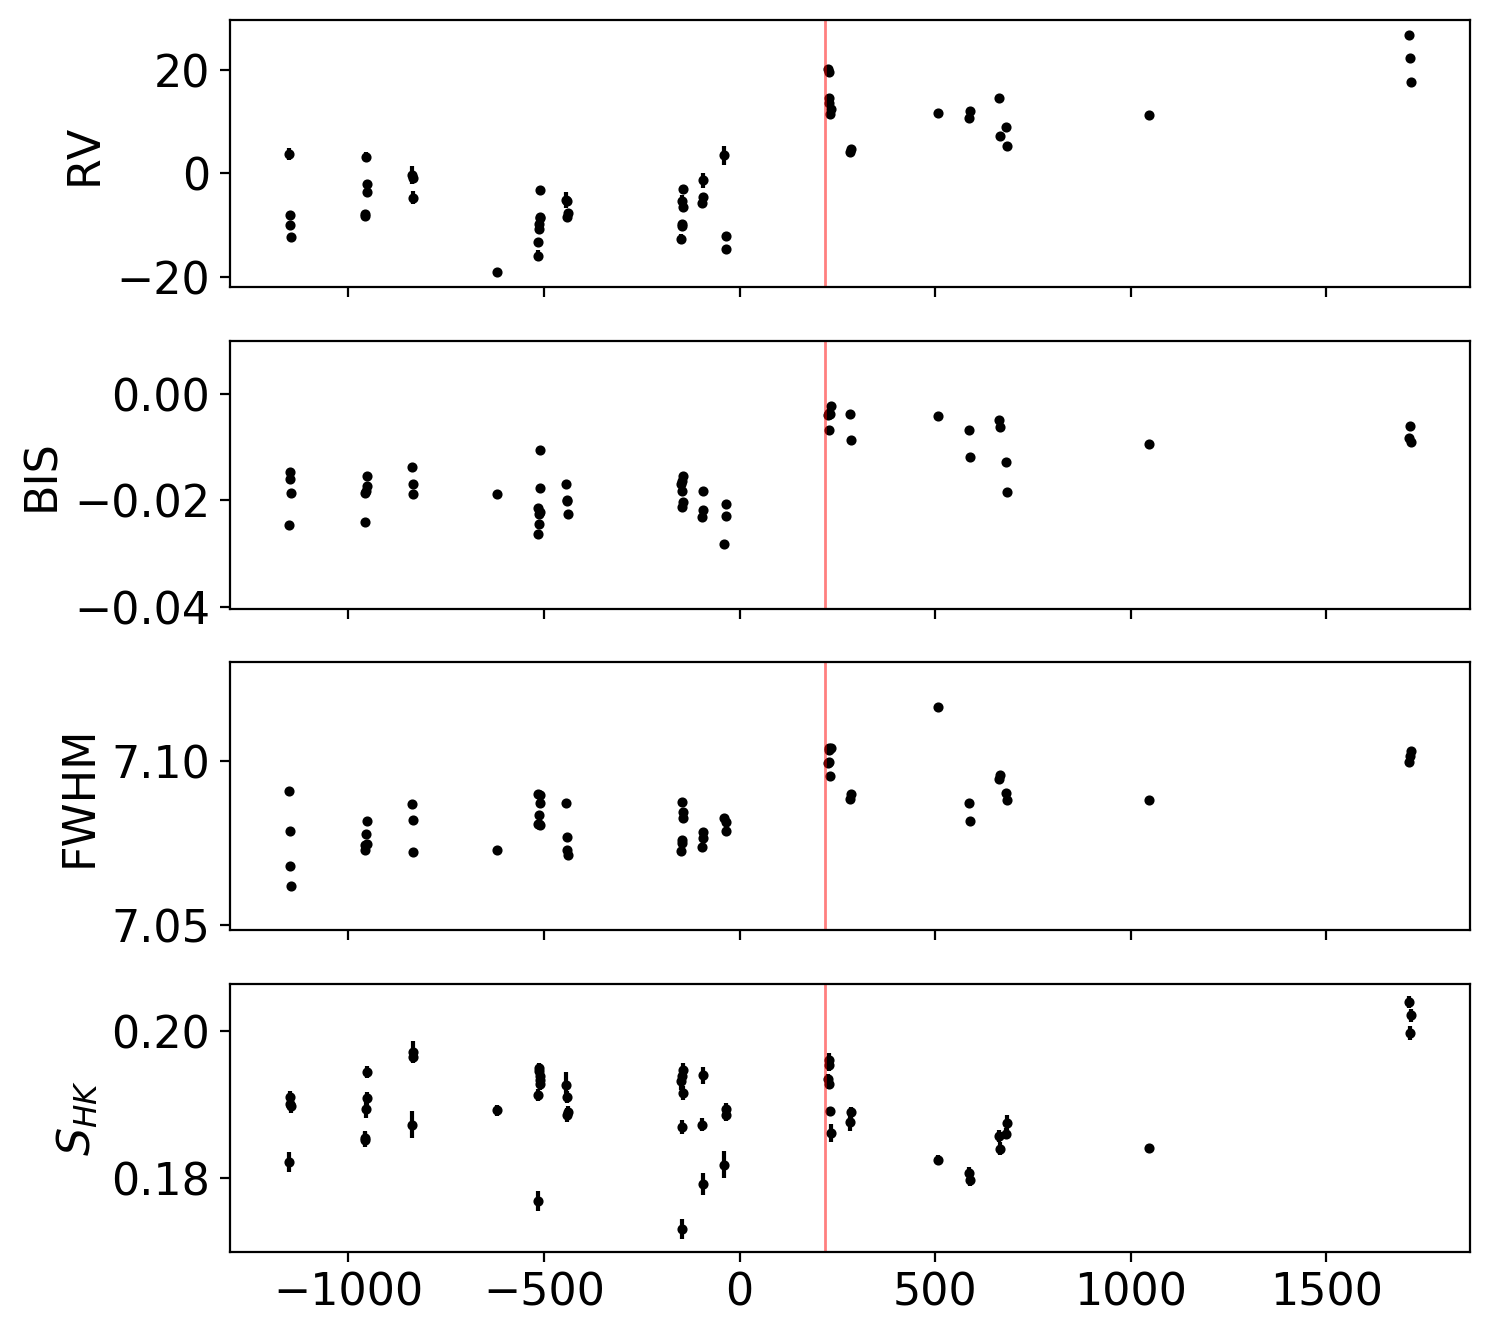

In [9]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(8,8), sharex=True)
ax1.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv, c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV')

ax2.scatter(x_rv, bis_rv, c='k', s=7)
ax2.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax2.set_ylabel('BIS')

ax3.scatter(x_rv, fwhm_rv, c='k', s=7)
ax3.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax3.set_ylabel('FWHM')

ax4.errorbar(x_rv, shk, yerr=yerr_shk, fmt=",k", zorder=-10)
ax4.scatter(x_rv, shk, c='k', s=7)
ax4.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax4.set_ylabel('$S_{HK}$');

In [10]:
y_rv_guess = np.copy(y_rv)
y_rv_guess[pug] -= 15.4

peaks at:
34.60 days
34.52 days
99.98 days
1.09 days
99.29 days
59.15 days
1.01 days
1.09 days
1.01 days
504.36 days


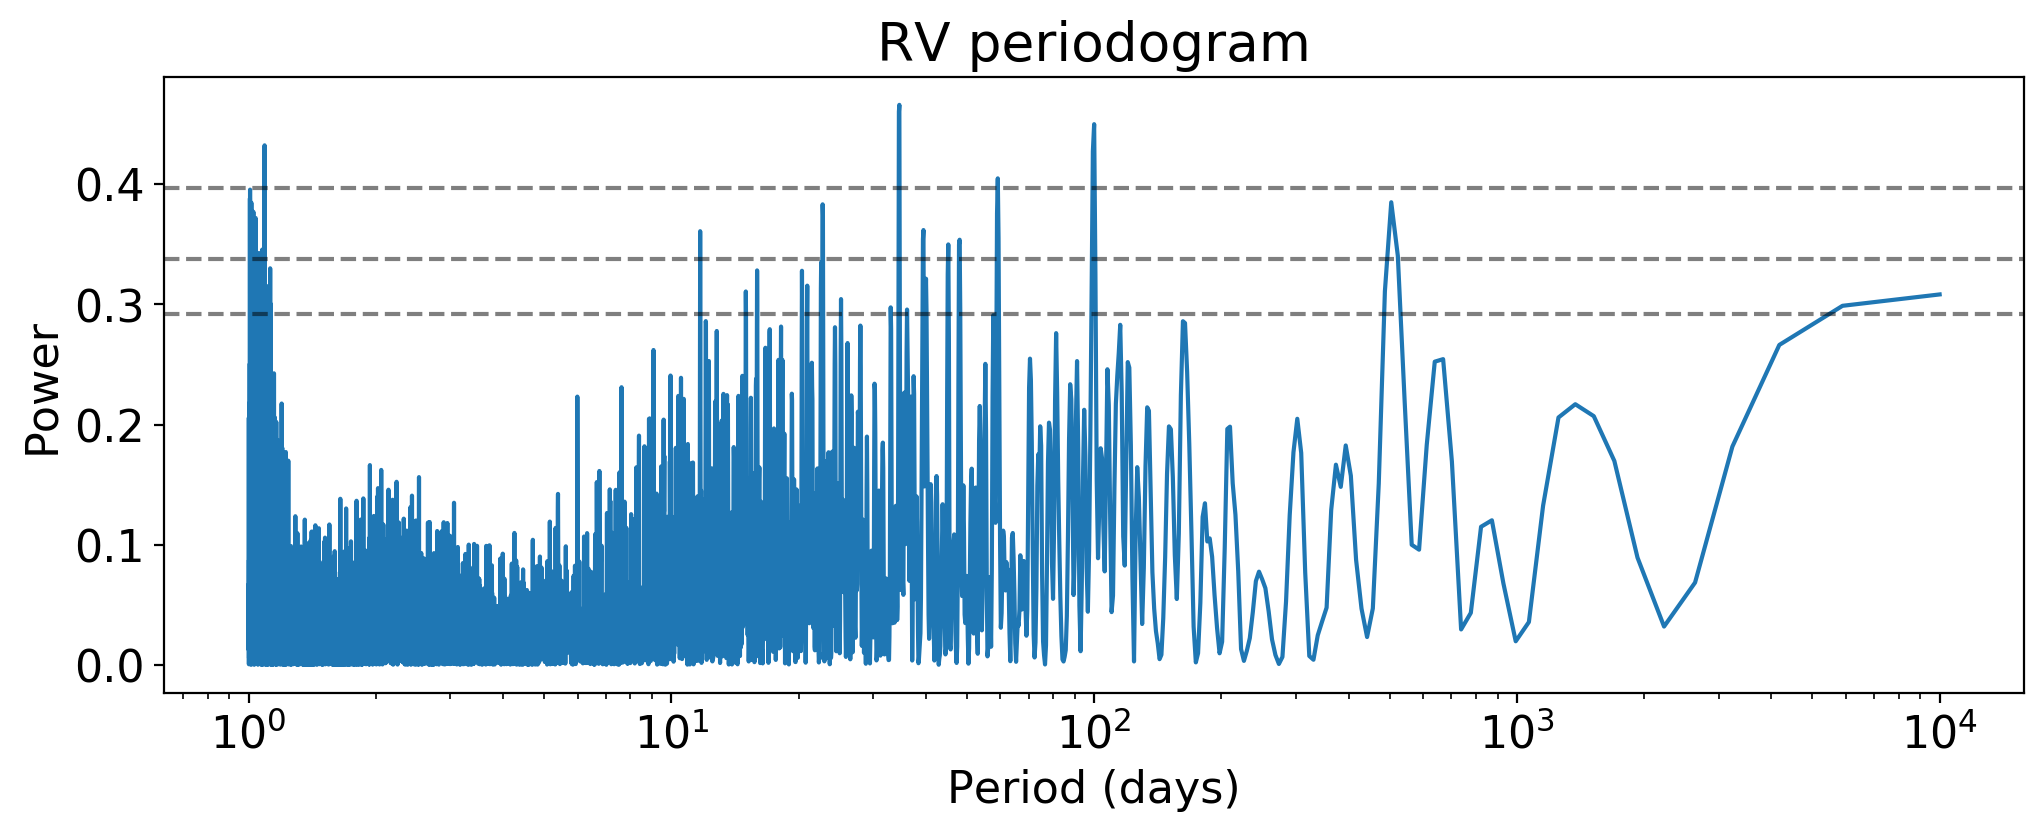

In [11]:
from astropy.timeseries import LombScargle
ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5, ls='--')
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.4696 with a false-alarm probability of 0.0003


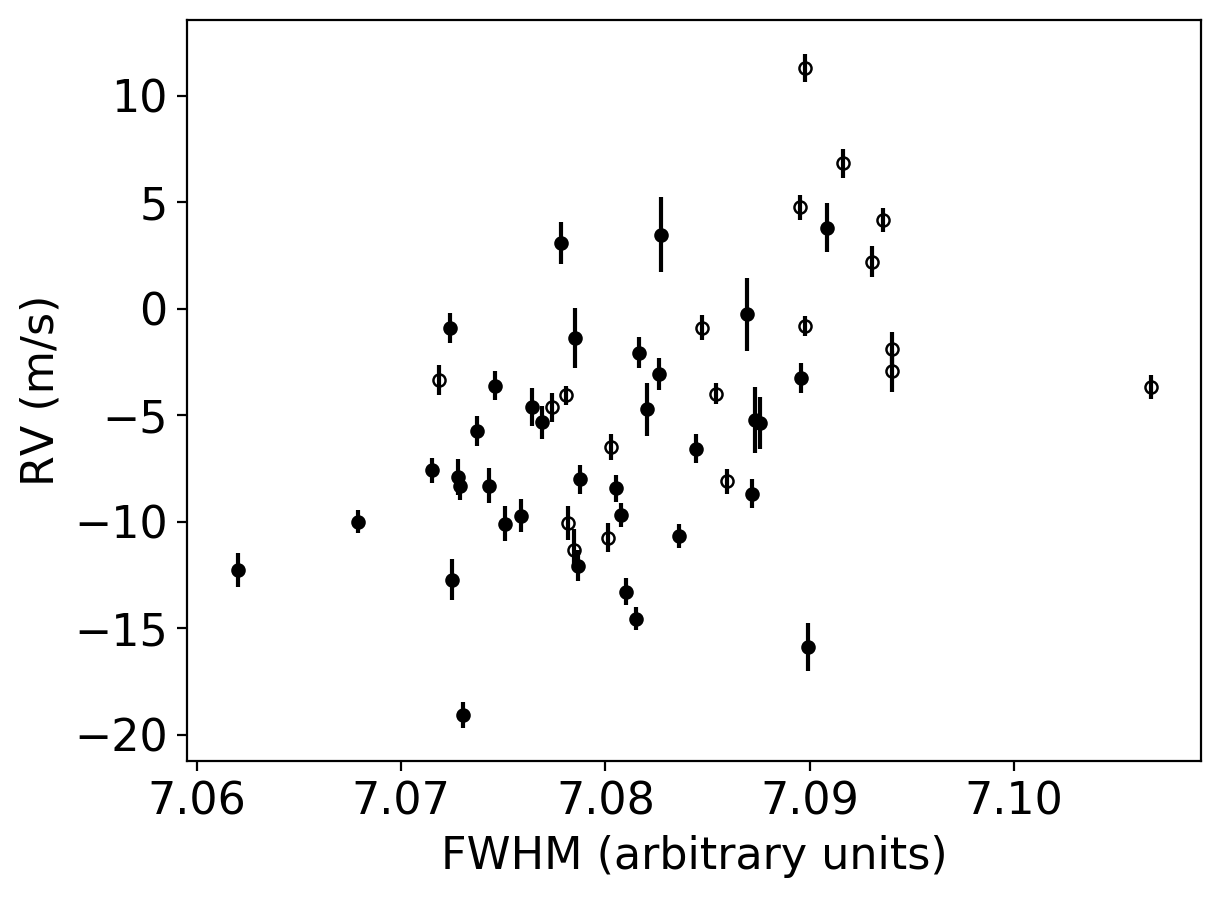

In [12]:
fwhm_rv_guess = np.copy(fwhm_rv)
fwhm_rv_guess[pug] -= 0.01

plt.errorbar(fwhm_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(fwhm_rv_guess, y_rv_guess, c='k', s=18)
plt.scatter(fwhm_rv_guess[pug], y_rv_guess[pug], c='w', s=6)
plt.xlabel('FWHM (arbitrary units)')
plt.ylabel('RV (m/s)')

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(fwhm_rv_guess, y_rv_guess)))

#mask = (fwhm_rv_guess > 1.8) | (fwhm_rv_guess > 0) & (y_rv_guess < -15)
#plt.scatter(fwhm_rv_guess[mask], y_rv_guess[mask], c='r', s=20);

plt.tight_layout()
plt.savefig(plot_dir+'rv_fwhm_corr.pdf')

peaks at:
30.88 days
30.94 days
1.03 days
1.03 days
30.81 days
1.02 days
1.03 days
1.02 days
19.53 days
31.01 days


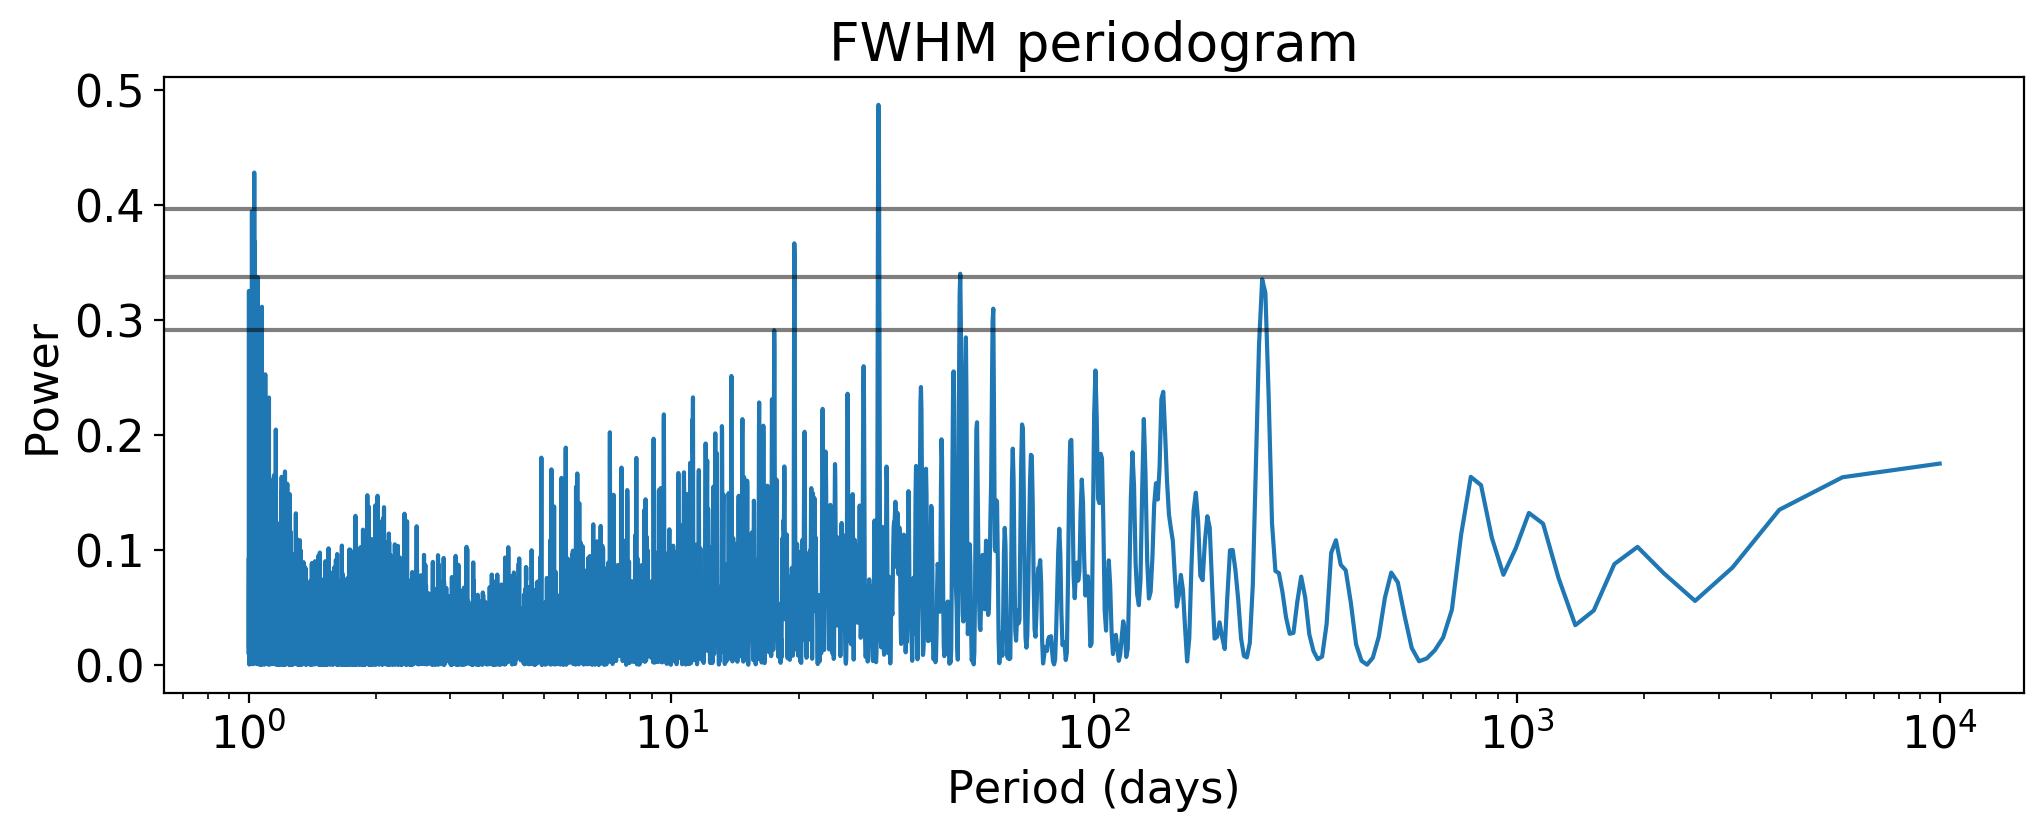

In [13]:
ls = LombScargle(x_rv, fwhm_rv_guess)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('FWHM periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.2386 with a false-alarm probability of 0.0794


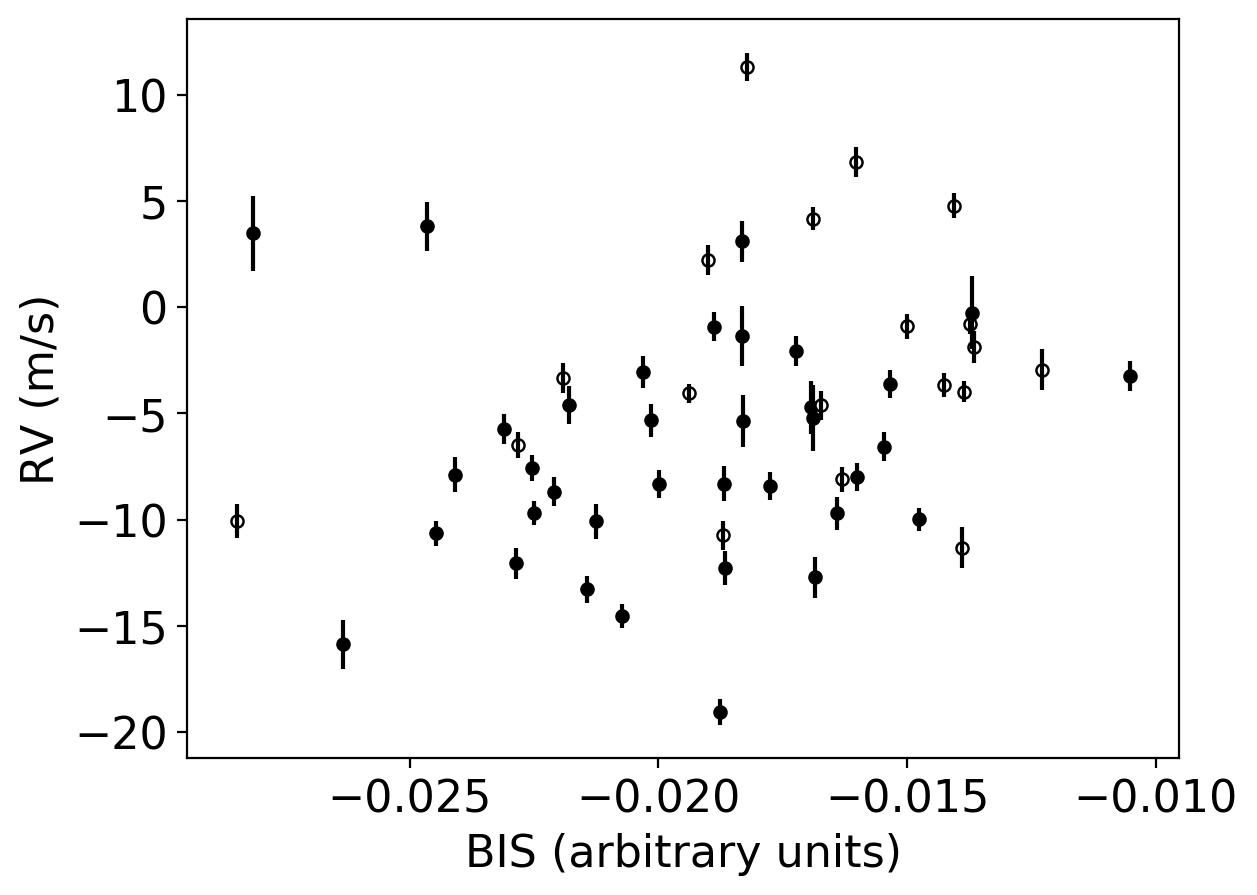

In [14]:
bis_rv_guess = np.copy(bis_rv)
bis_rv_guess[pug] -= 0.01

plt.errorbar(bis_rv_guess, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(bis_rv_guess, y_rv_guess, c='k', s=18)
plt.scatter(bis_rv_guess[pug], y_rv_guess[pug], c='w', s=6)

plt.xlabel('BIS (arbitrary units)')
plt.ylabel('RV (m/s)');

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(bis_rv_guess, y_rv_guess)))

#plt.scatter(bis_rv_guess[mask], y_rv_guess[mask], c='r', s=20);

peaks at:
1.01 days
1.01 days
1.01 days
71.55 days
27.99 days
71.19 days
1.06 days
48.54 days
48.87 days
1.02 days


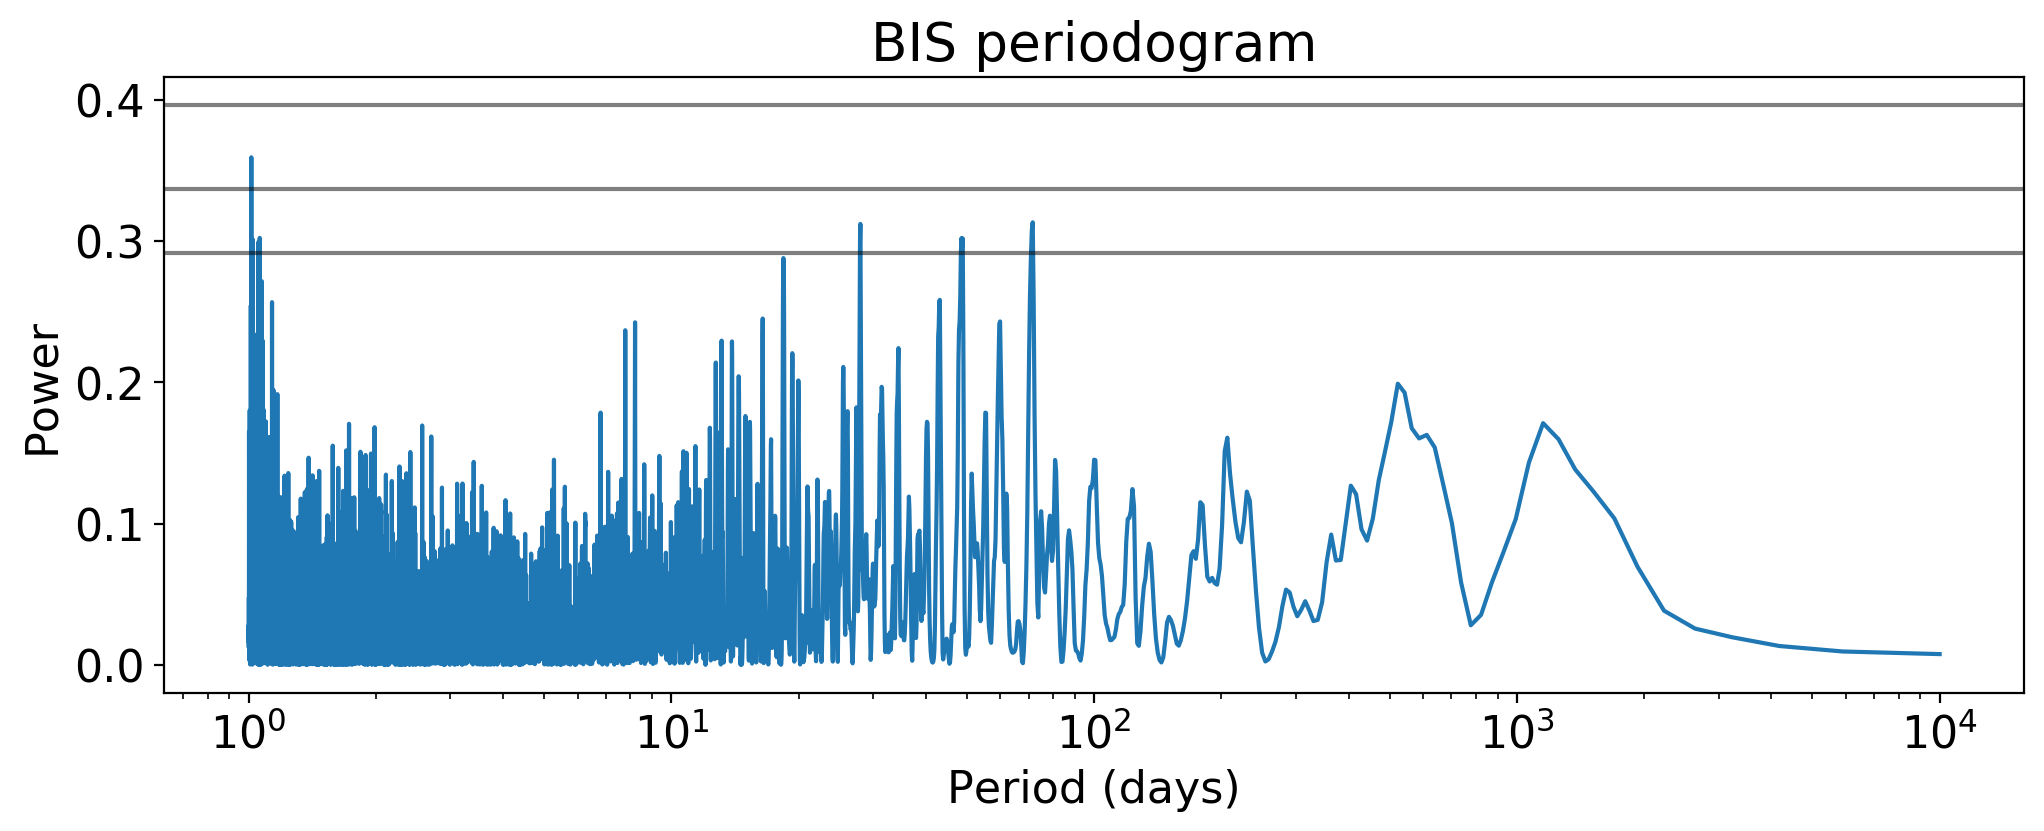

In [15]:
ls = LombScargle(x_rv, bis_rv_guess)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('BIS periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

Pearson R is 0.2432 with a false-alarm probability of 0.0736


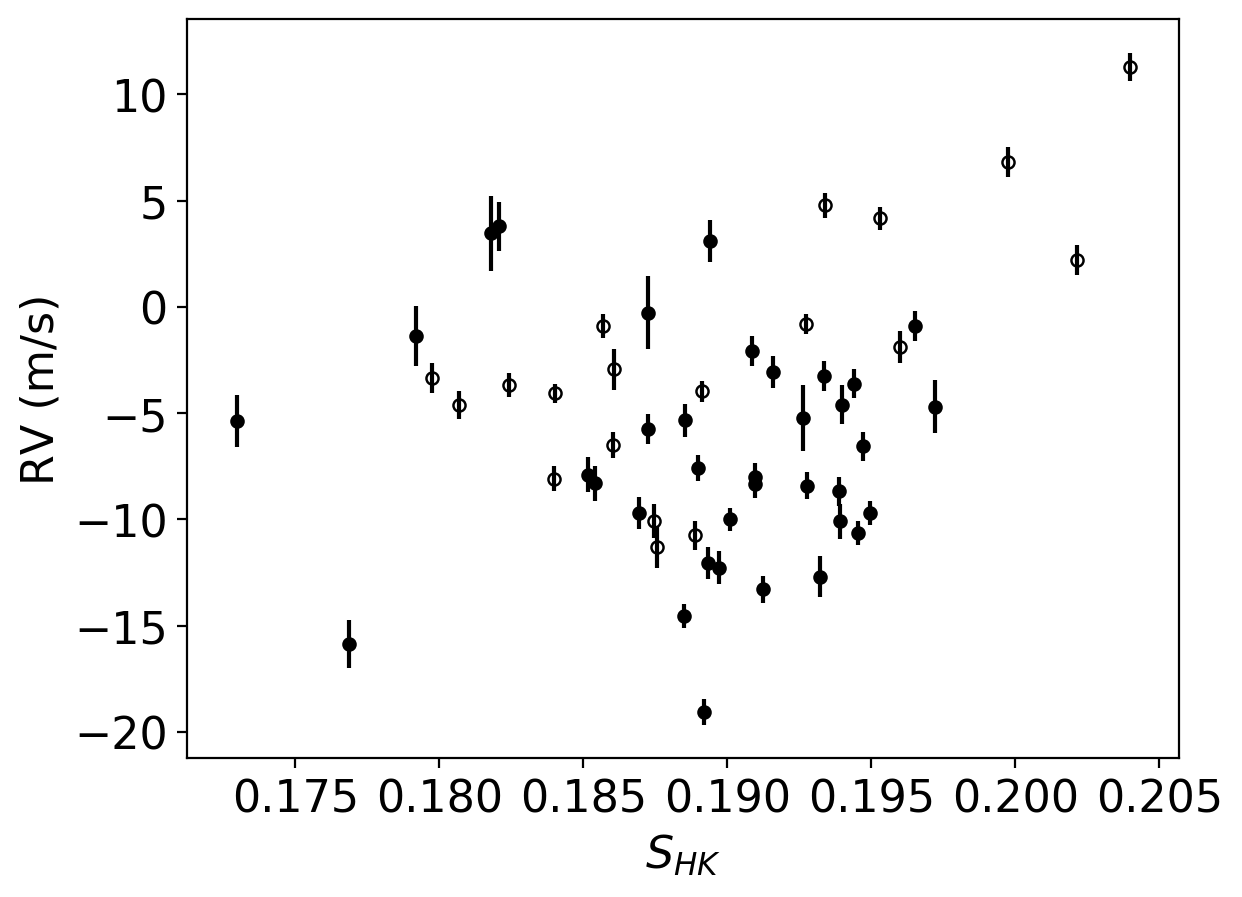

In [16]:
plt.errorbar(shk, y_rv_guess, yerr=yerr_rv, fmt=",k")
plt.scatter(shk, y_rv_guess, c='k', s=18)
plt.scatter(shk[pug], y_rv_guess[pug], c='w', s=6)
plt.xlabel('$S_{HK}$')
plt.ylabel('RV (m/s)');

from scipy.stats import pearsonr
print("Pearson R is {0:.4f} with a false-alarm probability of {1:.4f}".format(*pearsonr(shk, y_rv_guess)))

#plt.scatter(shk[mask], y_rv_guess[mask], c='r', s=20);

peaks at:
1.11 days
1.11 days
9.76 days
9.77 days
1.05 days
1.05 days
1.04 days
1.04 days
1.05 days
19.32 days


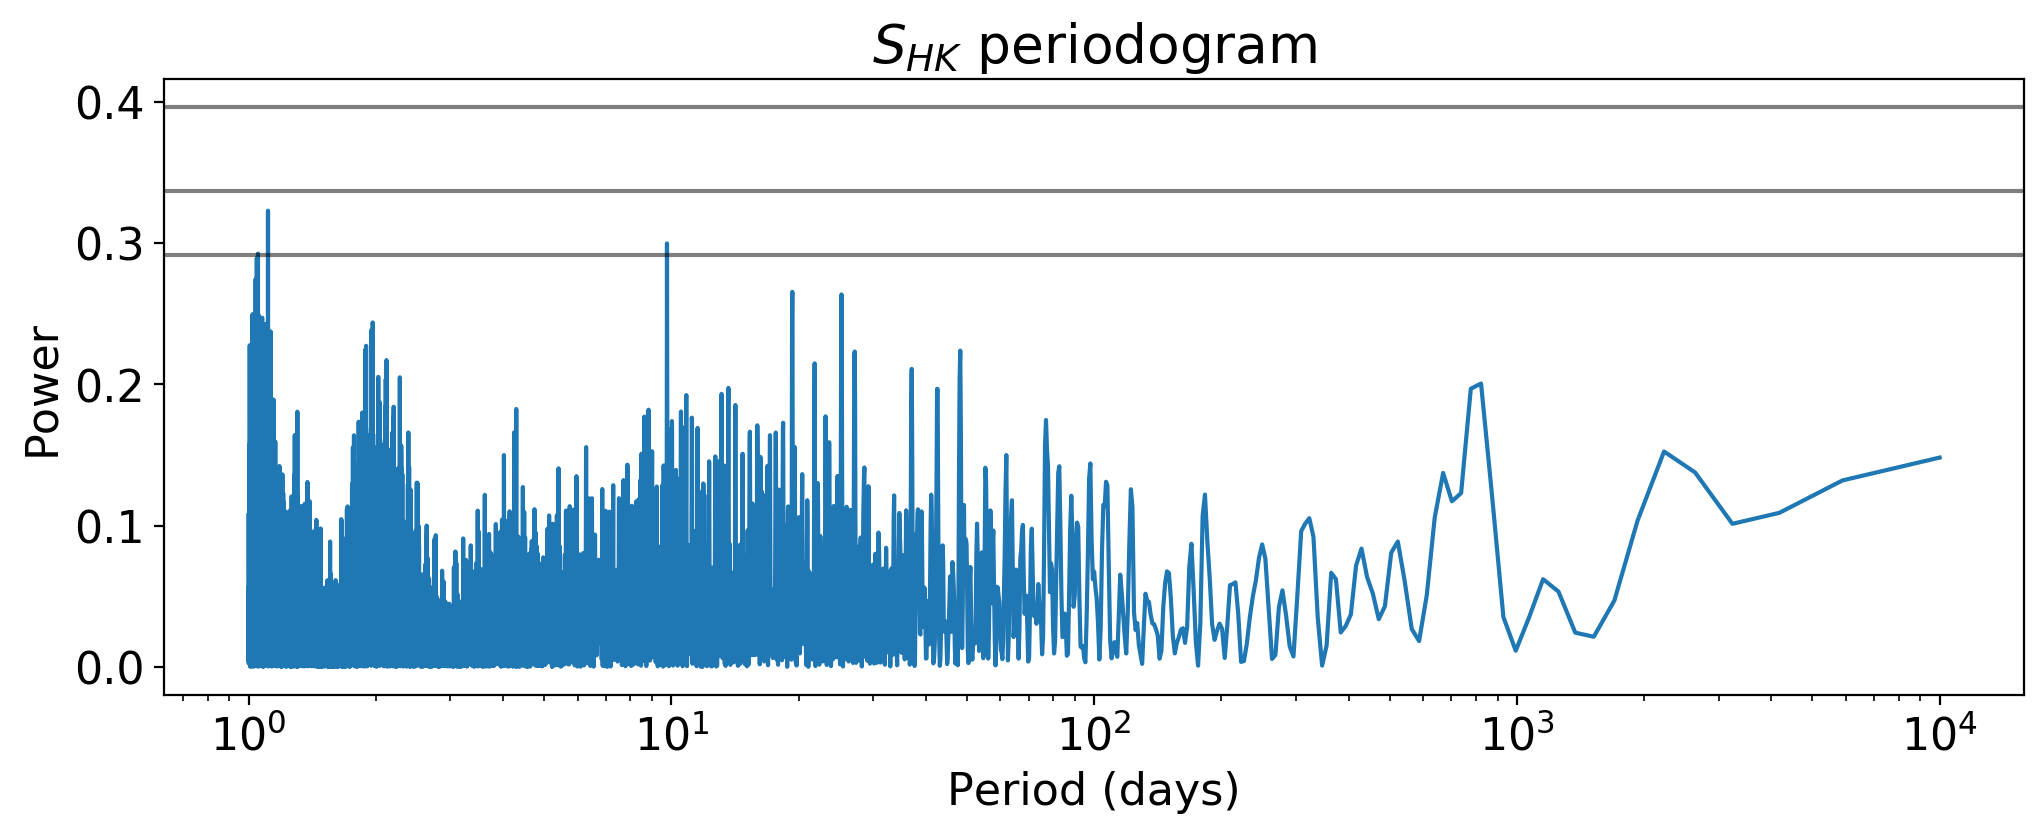

In [17]:
ls = LombScargle(x_rv, shk)
freq, power = ls.autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
#ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('$S_{HK}$ periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

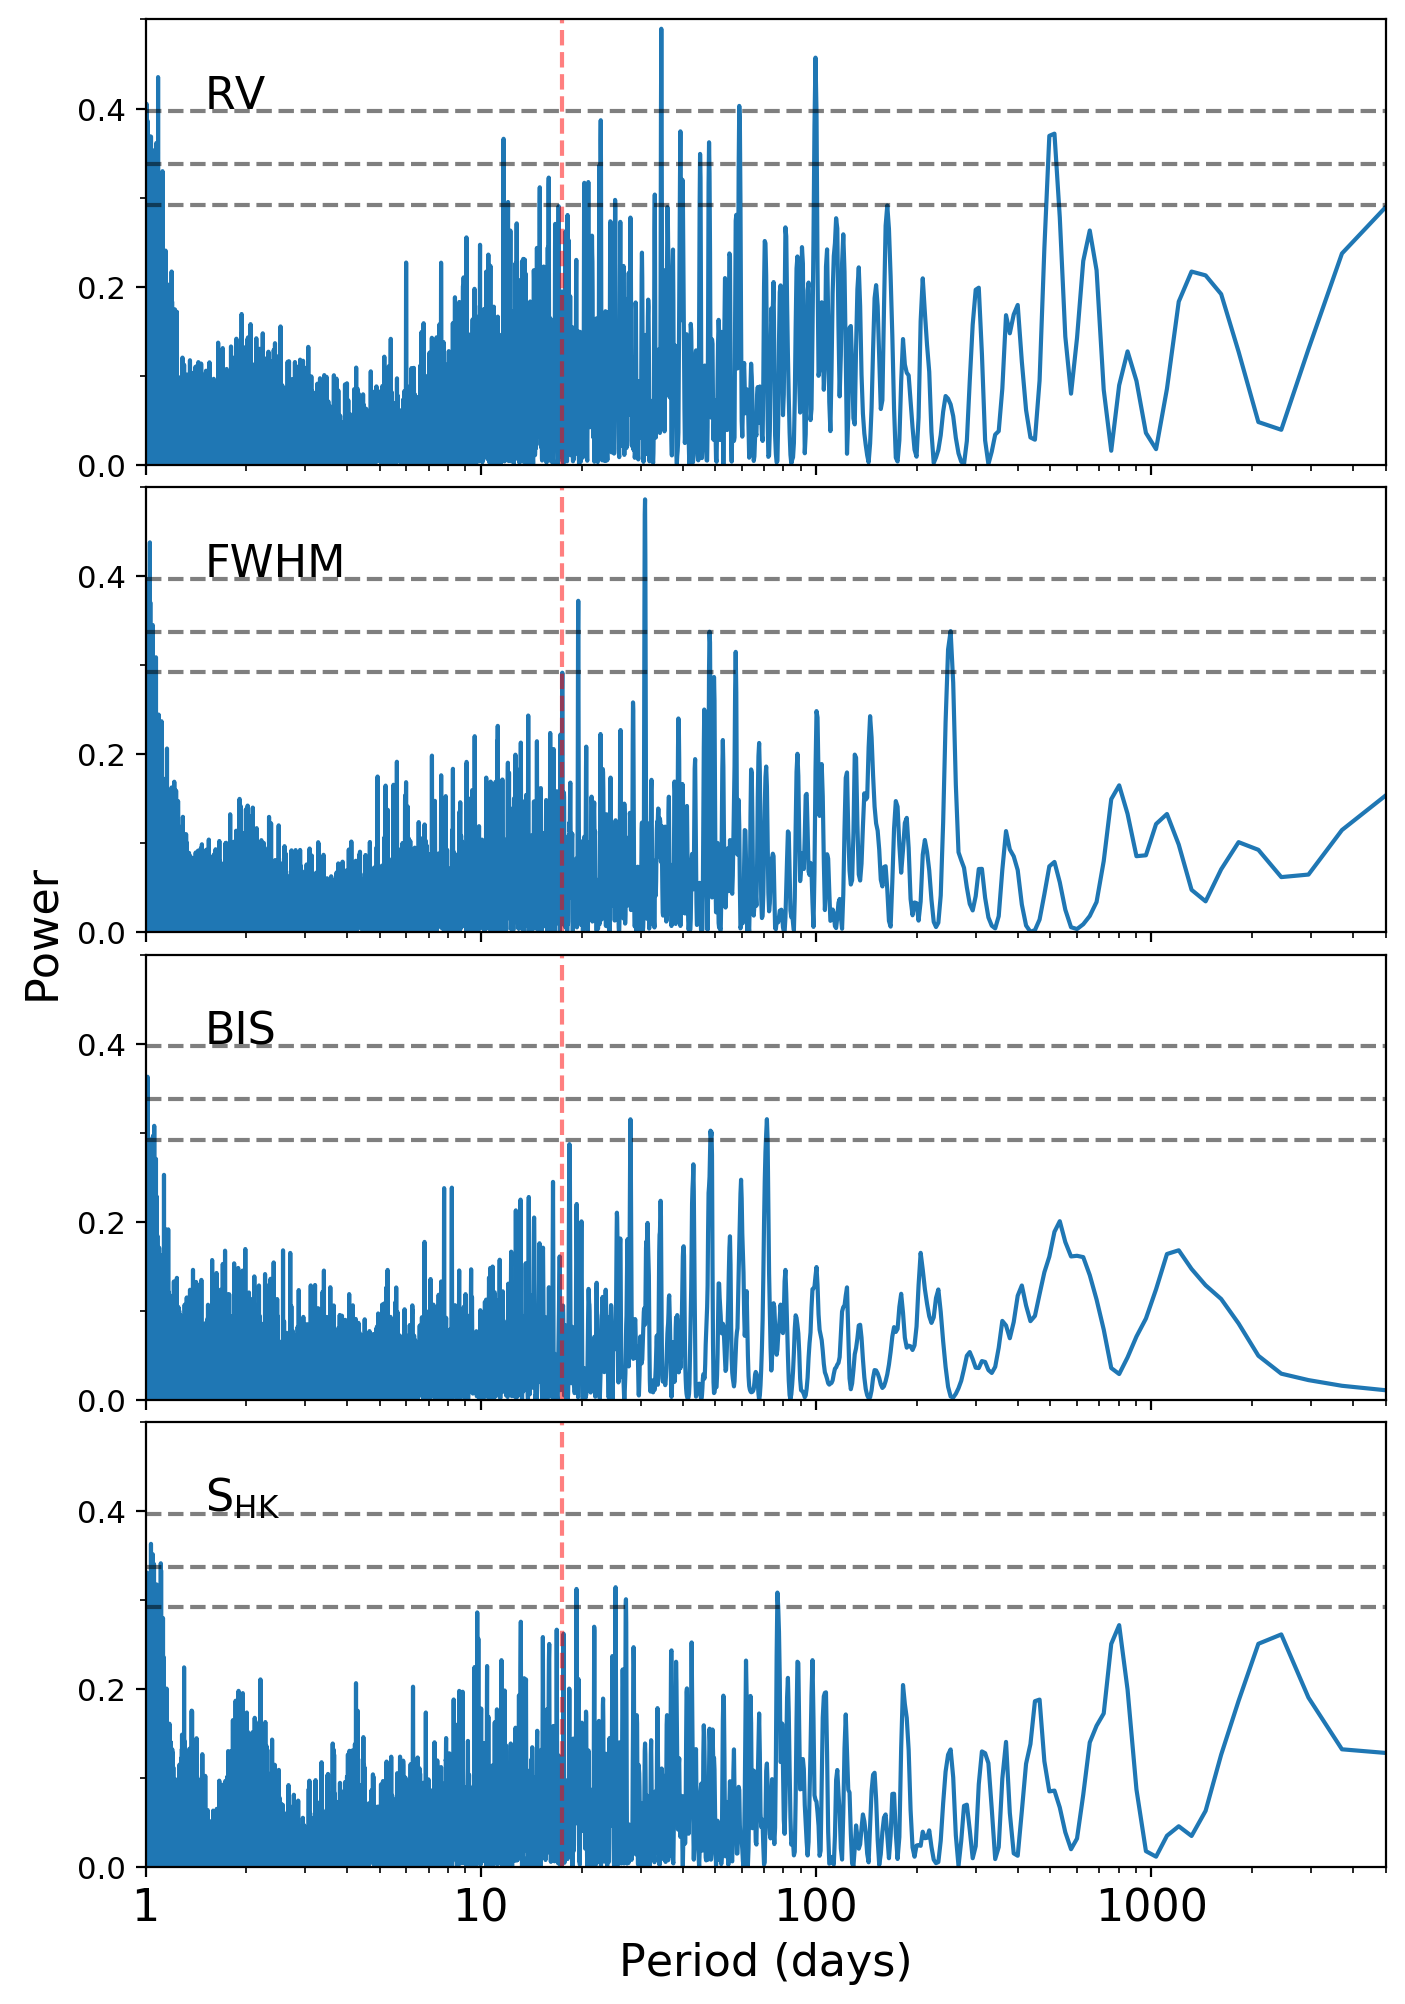

In [18]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8,12), sharex=True)

ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 
ax1.plot(1./freq, power)
ax1.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax1.text(1.5, 0.4, 'RV')

power = LombScargle(x_rv, fwhm_rv_guess).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax2.plot(1./freq, power)
ax2.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax2.axhline(f, c='k', alpha=0.5, ls='--')
ax2.text(1.5, 0.4, 'FWHM')

power = LombScargle(x_rv, bis_rv_guess).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax3.plot(1./freq, power)
ax3.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax3.axhline(f, c='k', alpha=0.5, ls='--')
ax3.text(1.5, 0.4, 'BIS')

power = LombScargle(x_rv, shk, yerr_shk).power(freq)
fal = ls.false_alarm_level(probabilities) 
ax4.plot(1./freq, power)
ax4.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax4.axhline(f, c='k', alpha=0.5, ls='--')
ax4.text(1.5, 0.4, 'S$_{\mathrm{HK}}$')

for ax in (ax1,ax2,ax3,ax4):
    ax.set_ylim([0.,0.5])
    ax.set_yticks([0.,0.2,0.4], minor=False)
    ax.set_yticks([0.1,0.3,0.5], minor=True)
    ax.tick_params(labelsize='x-small', axis='y')


ax1.set_xscale('log')
ax1.set_xlim([1.,5.e3])
ax4.set_xlabel('Period (days)')
ax4.set_xticklabels(['0.1','1', '10', '100', '1000'])

fig.text(0.06,0.5,'Power',rotation=90,va='center',ha='center')
plt.subplots_adjust(hspace=0.05)
#plt.savefig(plot_dir+'periodograms.pdf');

#### Fit an initial model without planets:

In [19]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    with pm.Model() as model:
        # RV jitter & a quadratic RV trend
        #logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        #logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=0.01, sd=1) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=0.01, sd=1) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)

        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
            bis_offset = pm.Deterministic("bis_offset", pug*offset_pug_bis)
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0] 
            fwhm_offset = pm.Deterministic("fwhm_offset", pug*offset_pug_fwhm)
        bkg = pm.Deterministic("bkg", bkg_terms)
        
        rv_offset = pm.Deterministic("rv_offset", pug*offset_pug + tt.dot(A, trend))
        


        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", bkg)
        
        err_pre = tt.sqrt(yerr_rv[~pug]**2)
        err_pug = tt.sqrt(yerr_rv[pug]**2)
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        #err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        #err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        #pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        #pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])
        
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        #map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug]) 
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [20]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [offset_pug, trend]
13it [00:00, 24.84it/s, logp=-1.307553e+03] 
message: Optimization terminated successfully.
logp: -3691.6956113568986 -> -1307.552691651883
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
32it [00:00, 449.60it/s, logp=-1.299171e+03] 
message: Optimization terminated successfully.
logp: -1307.552691651883 -> -1299.171008761396
optimizing logp for variables: [trend_fwhm, offset_pug_fwhm, trend, offset_pug]
51it [00:00, 595.49it/s, logp=-1.250527e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1299.171008761396 -> -1250.5270609917209


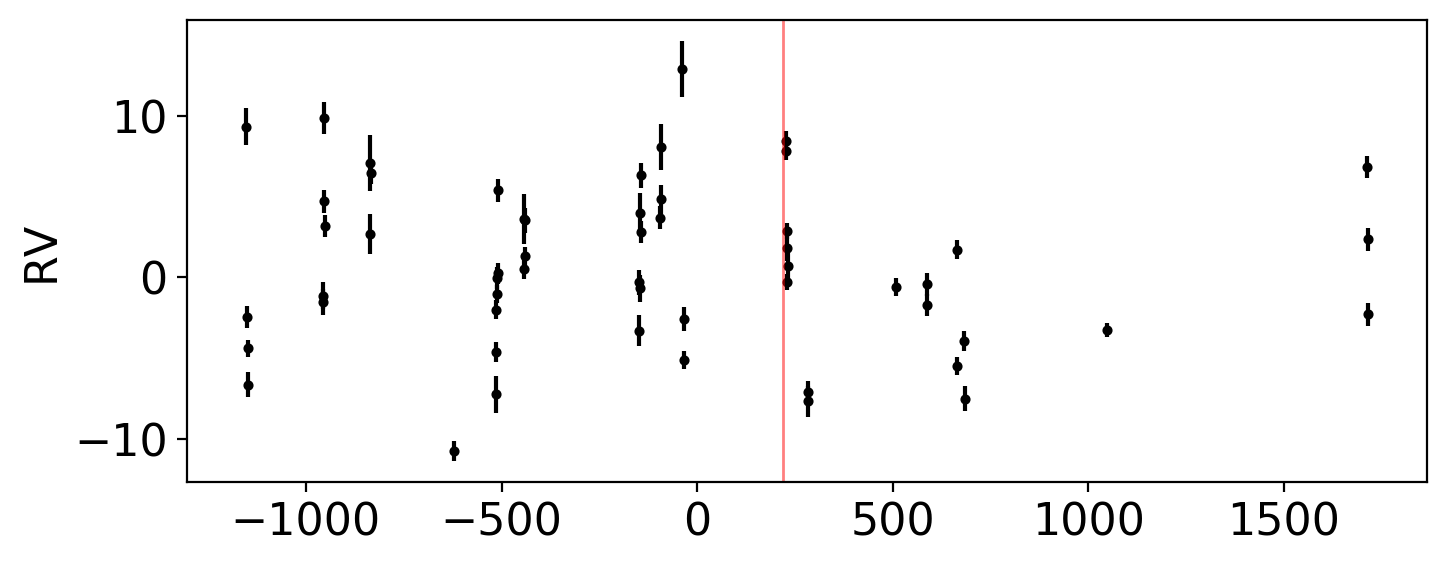

In [21]:
fig, ax1 = plt.subplots(1,1, figsize=(8,3), sharex=True)
ax1.errorbar(x_rv, y_rv - map_soln['bkg'], yerr=yerr_rv, fmt=",k", zorder=-10)
ax1.scatter(x_rv, y_rv - map_soln['bkg'], c='k', s=7)
ax1.axvline(HARPS_upgrade, c='r', alpha=0.5, lw=1)
ax1.set_ylabel('RV');

Periodogram of residuals:

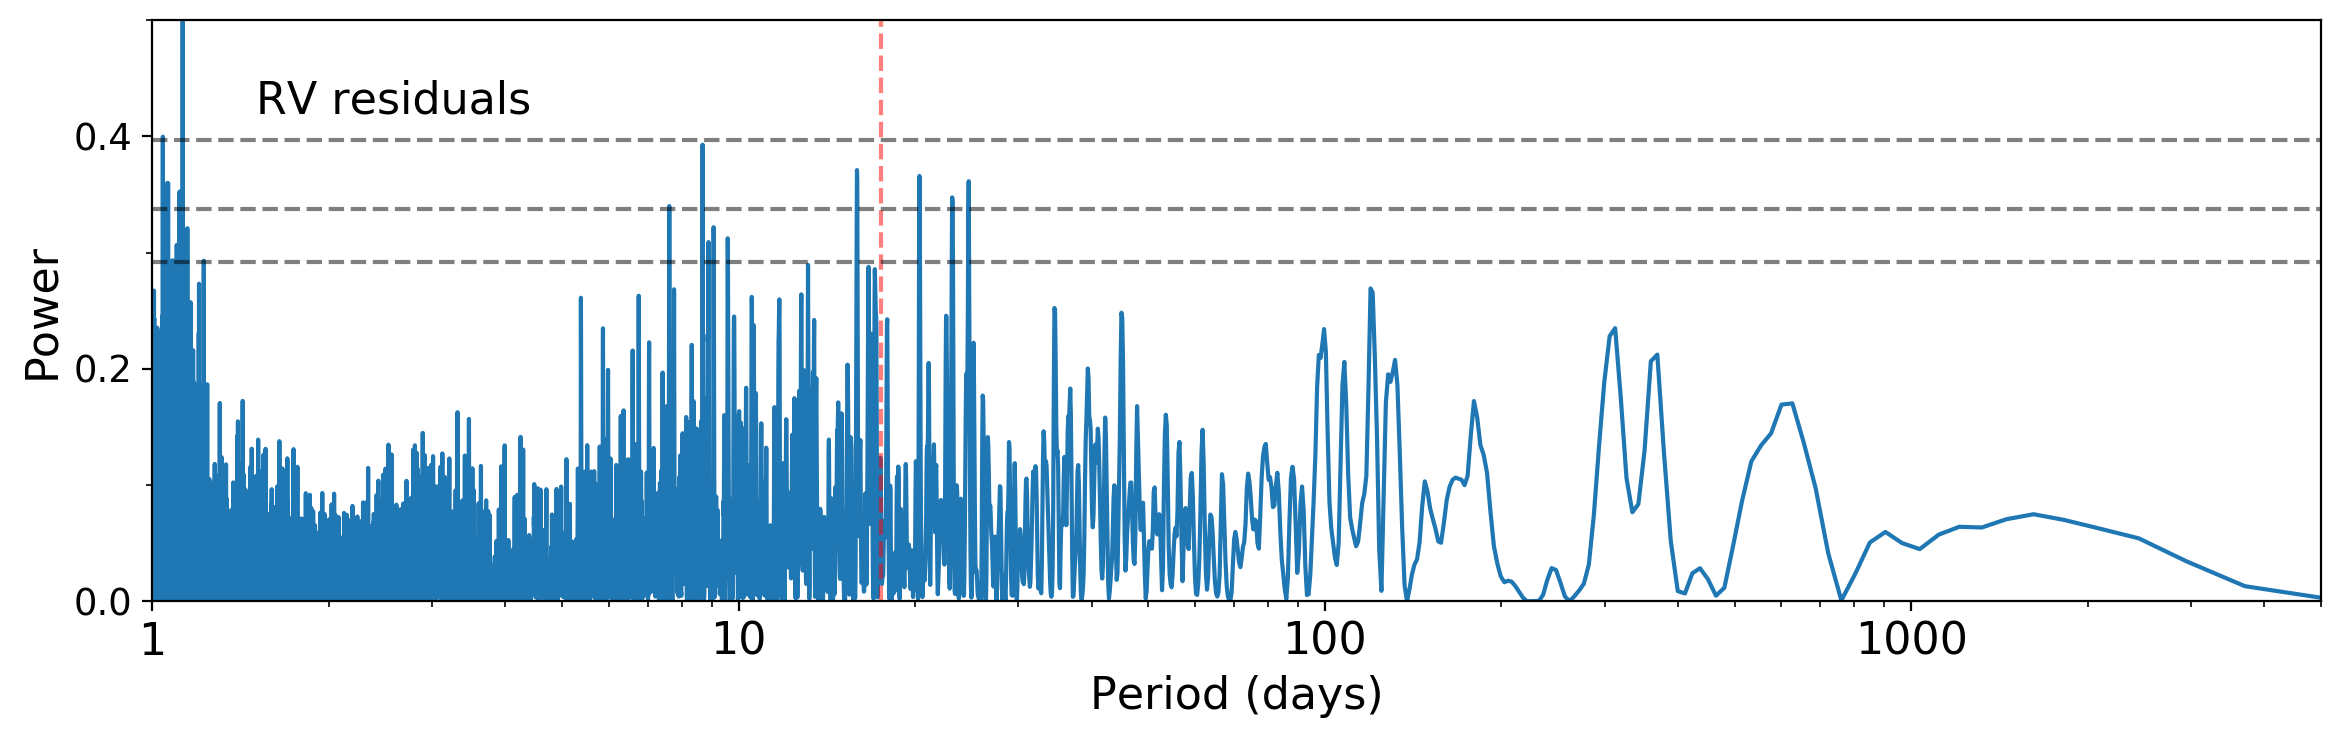

In [22]:
y_rv_resids = y_rv - map_soln['bkg']

ls = LombScargle(x_rv, y_rv_resids, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)

probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(17.47114, c='r', alpha=0.5, ls='--')
for f in fal:
    ax.axhline(f, c='k', alpha=0.5, ls='--')
ax.text(1.5, 0.42, 'RV residuals')
ax.set_xscale('log')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
ax.set_xlim([1.,5.e3])
ax.set_ylim([0.,0.5])
ax.set_yticks([0.,0.2,0.4], minor=False)
ax.set_yticks([0.1,0.3,0.5], minor=True)
ax.tick_params(labelsize='small', axis='y')
ax.set_xticklabels(['0.1','1', '10', '100', '1000'])
fig.tight_layout()
plt.savefig(plot_dir+'periodogram_resids1.pdf');

peaks at:
15.93 days
15.92 days
24.68 days
20.34 days
23.17 days
20.37 days
23.13 days
24.64 days
15.90 days
15.95 days


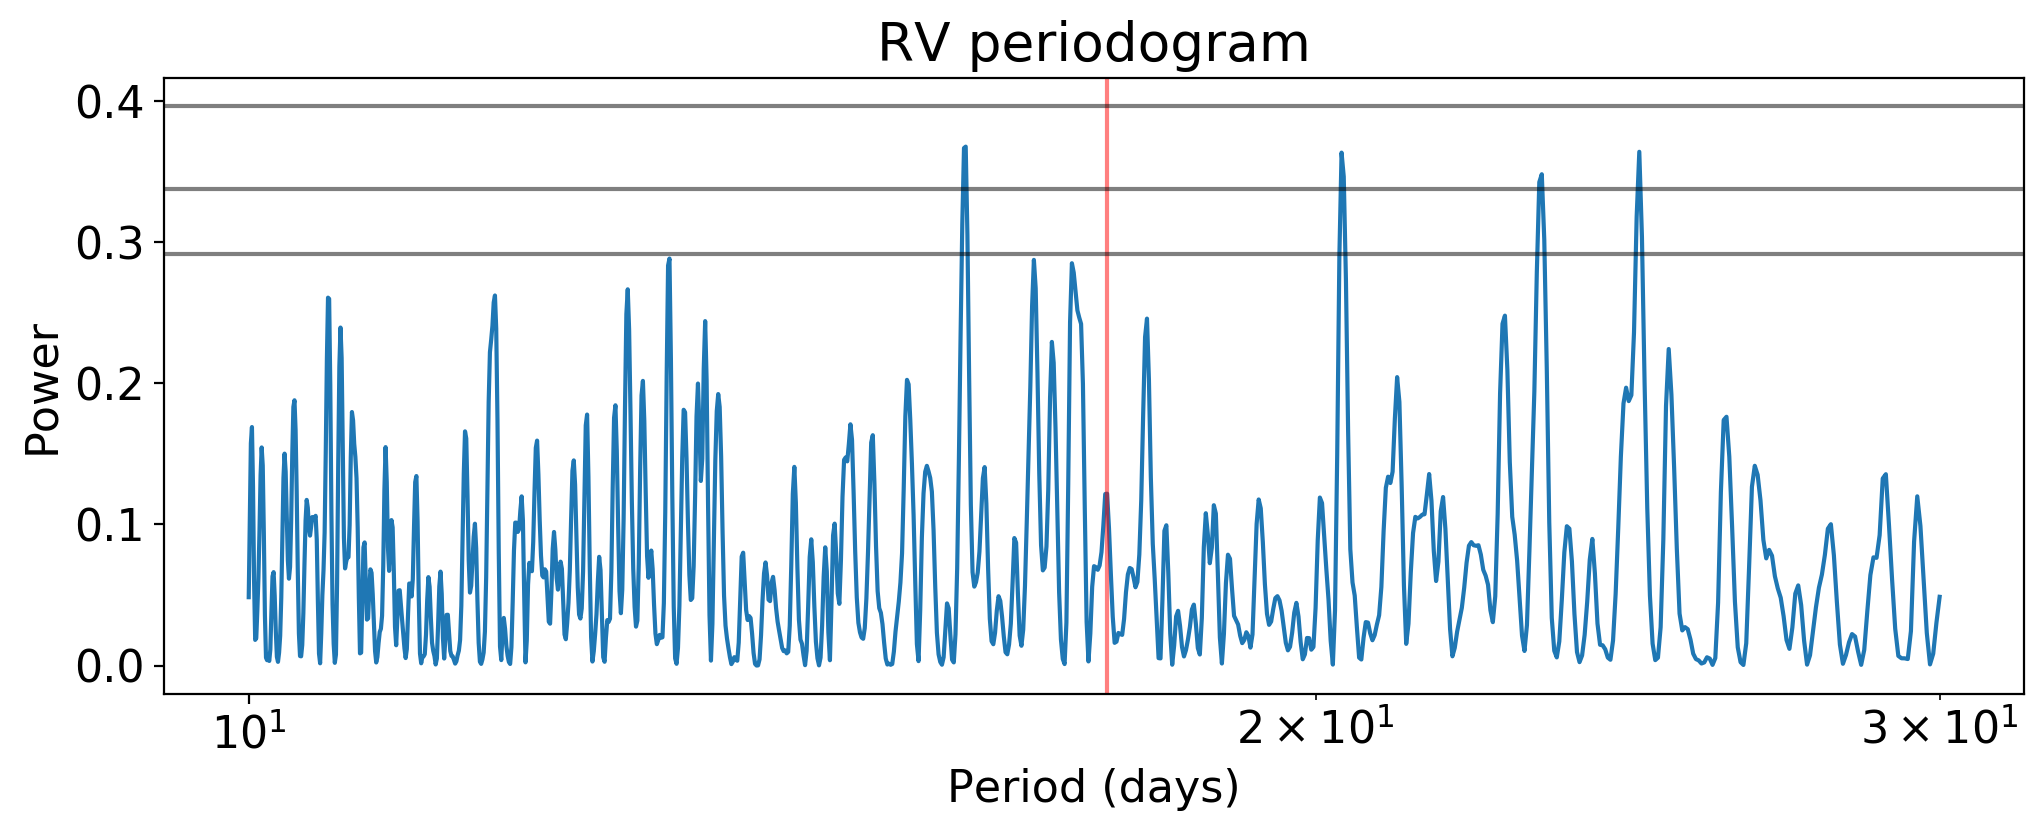

In [23]:
ls = LombScargle(x_rv, y_rv_resids, yerr_rv)
freq, power = ls.autopower(minimum_frequency=1./30.,
                                                   maximum_frequency=0.1)

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(17.47114, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

### Log-likelihood periodogram:
Made by fitting the above activity/instrumental model jointly with a sinusoid at each period in a grid and marginalizing over all terms to get the best possible likelihood at each period.

In [24]:
import tqdm

xs = x_rv
ys = y_rv
ivars = 1./yerr_rv**2

#a, b, c1, c2, d, k, h = param

def design_matrix(P):
    A = np.zeros((len(xs),7))
    A[:,0] = xs**2
    A[:,1] = xs
    A[:,2] = np.invert(pug).astype(int)
    A[:,3] = pug.astype(int)
    A[:,4] = fwhm_rv
    A[:,5] = np.sin(2*np.pi / P * xs)
    A[:,6] = np.cos(2*np.pi / P * xs)
    return A

def loglike(A, param):
    resids = ys - np.dot(A,param)
    return -0.5 * np.sum(resids**2 * ivars)

def best_param(A, cov=True):
    # returns the optimized parameters for a given design matrix A
    # if cov, return a tuple (best_param, cov)
    ATA = np.dot(A.T, ivars[:, None] * A)
    ATy = np.dot(A.T, ivars * ys)
    soln = np.linalg.solve(ATA, ATy)
    if cov:
        return soln, ATA
    return soln

ps = np.logspace(0,3,num=10000) # period grid
loglikes = np.zeros_like(ps)
solns = np.zeros((len(ps),7))
for i,p in tqdm.tqdm(enumerate(ps)):
    A = design_matrix(p)
    soln, cov = best_param(A)
    solns[i,:] = soln
    loglikes[i] = loglike(A, soln)

10000it [00:00, 23414.49it/s]


In [25]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ps, loglikes)
ax.set_xscale('log')
ax.set_title('RV likelihood periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('ln(like)')
ax.axvline(17.4714, color='orange', alpha=0.8)
ax.text(18,-600,'17.47 days', color='orange')
print("peaks at:")
sorted_peaks = ps[np.argsort(loglikes)[::-1]]
for i in range(10):
    print("{0:.2f} days".format(sorted_peaks[i]))

peaks at:
17.07 days
1.06 days
17.06 days
17.08 days
15.92 days
15.91 days
24.63 days
24.62 days
15.93 days
24.65 days


In [26]:
np.shape(loglikes)

(10000,)

In [27]:
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
ax1.plot(ps, np.sqrt(solns[:,5]**2 + solns[:,6]**2))
ax1.set_xscale('log')
ax1.set_xlabel('Period (days)')
ax1.set_ylabel(r'best-fit K (m s${-1}$)')
ax1.axvline(17.4714, color='orange', alpha=0.8)
ax1.text(18,3,'17.47 days', color='orange');

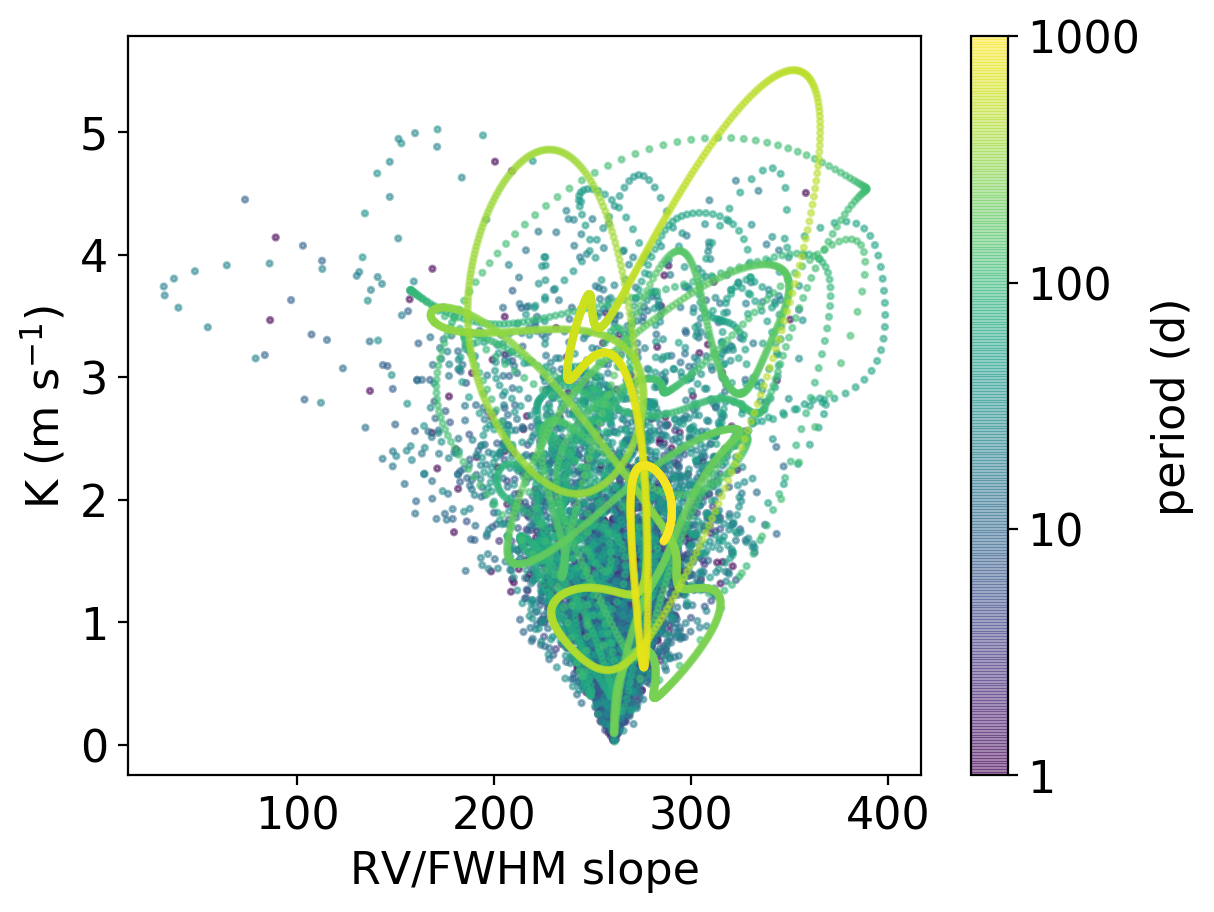

In [28]:
from matplotlib import cm
plt.scatter(solns[:,4], np.sqrt(solns[:,5]**2 + solns[:,6]**2), c=np.log10(ps), alpha=0.5, s=4, cmap=cm.viridis)
cbar = plt.colorbar()
ticks = [1,10,100,1000]
cbar.set_ticks(np.log10(ticks))
cbar.ax.set_yticklabels(ticks)
cbar.ax.set_ylabel('period (d)')
plt.xlabel('RV/FWHM slope')
plt.ylabel(r'K (m s$^{-1}$)');

In [29]:
plt.scatter(solns[:,4], np.sqrt(solns[:,5]**2 + solns[:,6]**2), c=loglikes, alpha=0.5, s=4)
cbar = plt.colorbar()
#ticks = [1,10,100,1000]
#cbar.set_ticks(np.log10(ticks))
#cbar.ax.set_yticklabels(ticks)
cbar.ax.set_ylabel('ln(likelihood)')
plt.xlabel('RV/FWHM slope')
plt.ylabel(r'K (m s$^{-1}$)');

In [30]:
ps_small = np.logspace(1,1.5,2000)
loglikes_small = np.zeros_like(ps_small)
solns_small = np.zeros((len(ps_small),7))
covs_small = np.zeros((len(ps_small),7,7))
for i,p in tqdm.tqdm(enumerate(ps_small)):
    A = design_matrix(p)
    soln, cov = best_param(A)
    solns_small[i,:] = soln
    covs_small[i,:,:] = cov
    loglikes_small[i] = loglike(A, soln)

2000it [00:00, 22298.21it/s]


In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(ps_small, loglikes_small)
#ax.set_xscale('log')
ax.set_title('RV likelihood periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('ln(like)')
ax.axvline(17.4714, color='orange', alpha=0.8)
ax.text(17.8,-650,'17.47 days', color='orange');

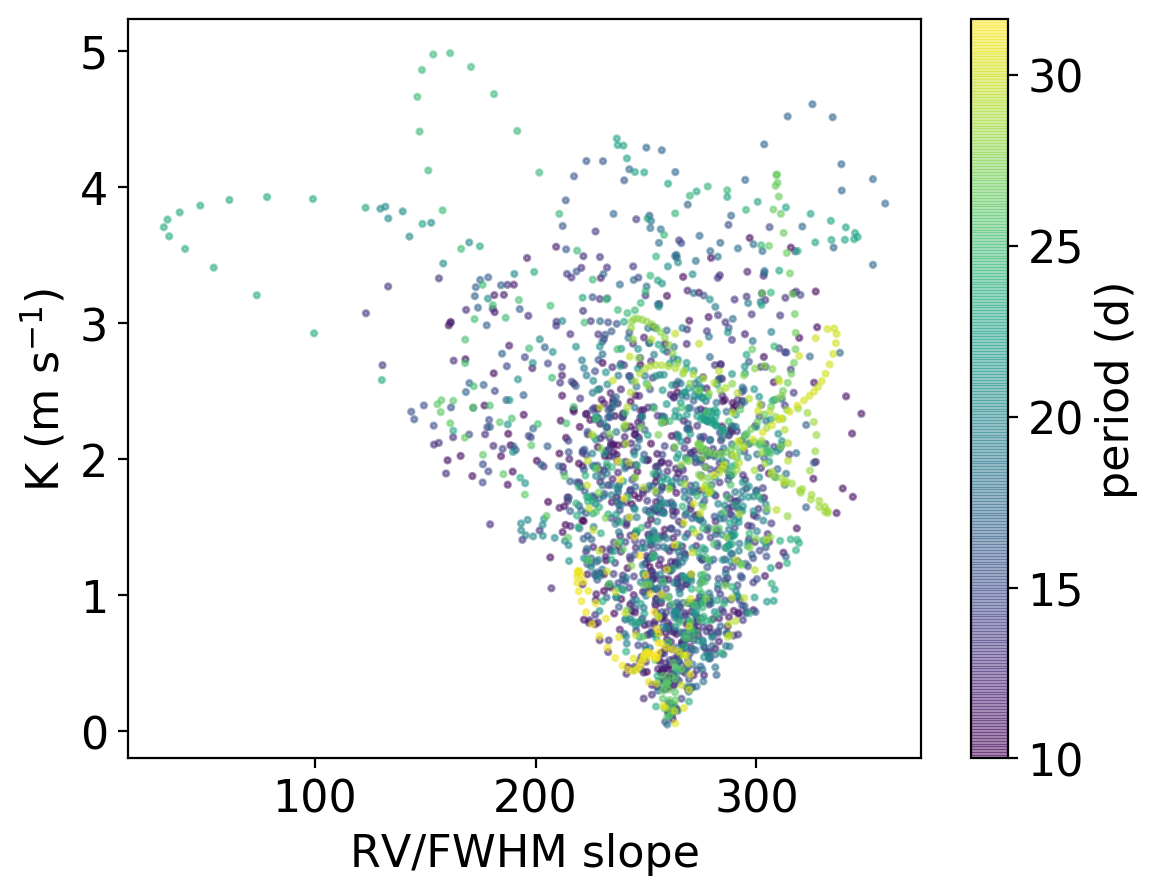

In [33]:
plt.scatter(solns_small[:,4], np.sqrt(solns_small[:,5]**2 + solns_small[:,6]**2), c=ps_small, alpha=0.5, s=4)
cbar = plt.colorbar()
#ticks = [1,10,100,1000]
#cbar.set_ticks(np.log10(ticks))
#cbar.ax.set_yticklabels(ticks)
cbar.ax.set_ylabel('period (d)')
plt.xlabel('RV/FWHM slope')
plt.ylabel(r'K (m s$^{-1}$)');

#### make a plot for the paper with both periodogram types:

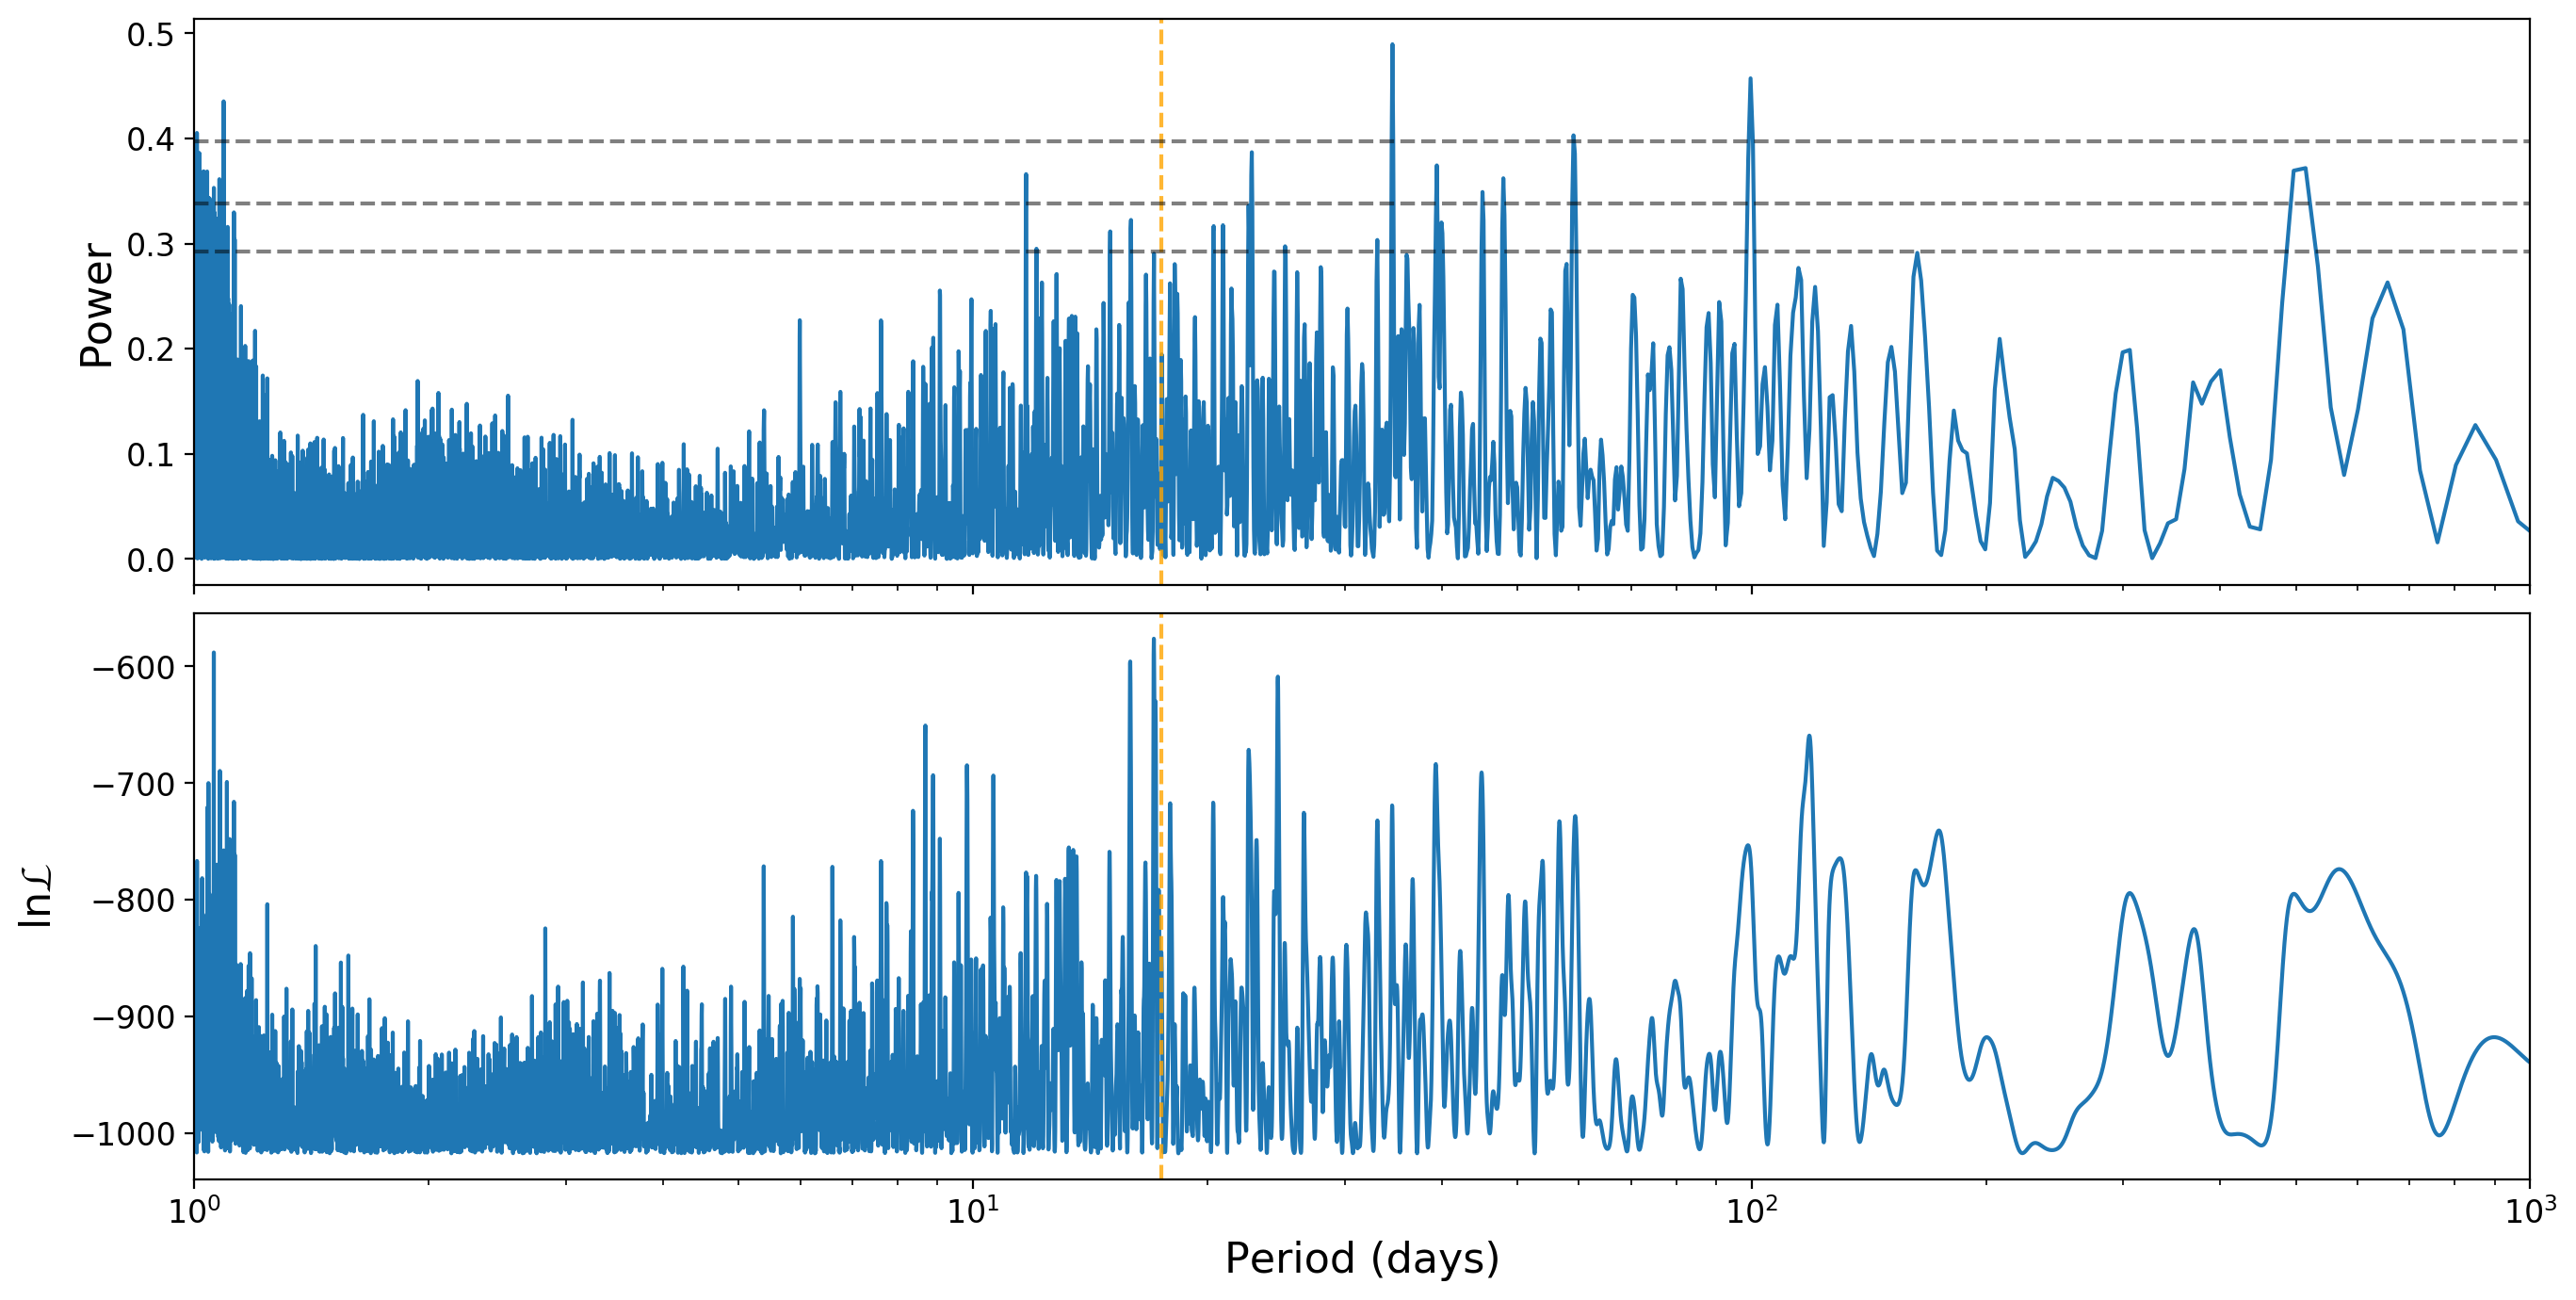

In [38]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(16,8), sharex=True)

ls = LombScargle(x_rv, y_rv_guess, yerr_rv)
freq, power = ls.autopower(minimum_frequency=2.e-4, maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 
ax1.plot(1./freq, power)
ax1.axvline(17.47114, c='orange', alpha=0.8, ls='--')
for f in fal:
    ax1.axhline(f, c='k', alpha=0.5, ls='--')
ax1.set_ylabel('Power')
ax1.set_xlim([1,1e3])


ax2.plot(ps, loglikes)
ax2.set_xscale('log')
ax2.set_xlabel('Period (days)')
ax2.set_ylabel(r'ln$\mathcal{L}$')
ax2.axvline(17.47114, color='orange', alpha=0.8, ls='--')

for ax in (ax1,ax2):
    ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.05)
plt.savefig(plot_dir+'periodograms.pdf')

#### Now get the best-fit planet (with eccentricity allowed), initializing around the expected transiting planet period:

In [39]:
# starting guesses:
#periods = np.array([17.47114, 120.])
#t0s = np.array([1661.0628, 1000.])

periods = np.array([17.47114])
t0s = np.array([1661.0628])

n_pl = len(periods)

In [40]:
msini = xo.estimate_minimum_mass(periods, x_rv, y_rv_guess, yerr_rv, t0s=t0s, m_star=mass_radius_mu[0])
msini = np.abs(msini.to(u.M_earth))
print(msini)

[6.09623183] earthMass


In [41]:
t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(start=None, bis=False, fwhm=False, rv_trend_order=1):
    if rv_trend_order < 1:
        assert False, "rv_trend_order must be >= 1"
    with pm.Model() as model:

        # Stellar properties
        mr_star = pm.Bound(pm.MvNormal, lower=0)(
            "mr_star",
            mu=mass_radius_mu,
            chol=np.linalg.cholesky(mass_radius_cov),
            shape=2,
            testval=mass_radius_mu)
        m_star = pm.Deterministic("m_star", mr_star[0])
        r_star = pm.Deterministic("r_star", mr_star[1])
        
        # Planets
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=10.0, shape=n_pl)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Uniform("t0", lower=t0s[0]-1.0, upper=t0s[0]+1.0, shape=n_pl)

        log_m_pl = pm.Bound(pm.Normal, lower=0.0)(
            "log_m_pl", mu=np.log(msini.value), sd=5, shape=n_pl)
        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        #ecc = xo.distributions.UnitUniform("ecc", testval=np.zeros(n_pl)+0.01, shape=n_pl)
        omega = xo.distributions.Angle("omega", shape=n_pl)
        
        
        # RV jitter & an RV trend
        logs_rv_pre = pm.Normal("logs_rv_pre", mu=np.log(np.median(yerr_rv[~pug])), sd=5)
        logs_rv_pug = pm.Normal("logs_rv_pug", mu=np.log(np.median(yerr_rv[pug])), sd=5)
        offset_pug = pm.Normal("offset_pug", mu=15.4, sd=0.4) # strong prior based on other solar twins
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
        if bis:
            offset_pug_bis = pm.Normal("offset_pug_bis", mu=1., sd=5) # weak prior from eyeballing
            trend_bis = pm.Normal("trend_bis", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
        if fwhm:
            offset_pug_fwhm = pm.Normal("offset_pug_fwhm", mu=1., sd=5) # weak prior from eyeballing
            trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.0**(1-np.arange(2))[::-1], shape=2)
            
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0,
            ecc=ecc, omega=omega,
            m_planet=m_pl, 
            m_planet_units=msini.unit)
        
        # Save some deterministics
        #dist_peri = 

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv, rv_trend_order)
        bkg_terms = pug*offset_pug + tt.dot(A, trend)
        bkg_noactivity = pm.Deterministic("bkg_noactivity", bkg_terms)
        if bis:
            A_bis = np.vander(bis_rv, 2)
            bkg_terms += tt.dot(A_bis, trend_bis) + pug*offset_pug_bis*trend_bis[0]
        if fwhm:
            A_fwhm = np.vander(fwhm_rv, 2)
            bkg_terms += tt.dot(A_fwhm, trend_fwhm) + pug*offset_pug_fwhm*trend_fwhm[0]            
        bkg = pm.Deterministic("bkg", bkg_terms)


        # The likelihood for the RVs
        if n_pl > 1:
            rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        else:
            rv_model = pm.Deterministic("rv_model", vrad + bkg)
        err_pre = tt.sqrt(yerr_rv[~pug]**2 + tt.exp(2*logs_rv_pre))
        err_pug = tt.sqrt(yerr_rv[pug]**2 + tt.exp(2*logs_rv_pug))
        pm.Normal("obs_pre", mu=rv_model[~pug], sd=err_pre, observed=y_rv[~pug])
        pm.Normal("obs_post", mu=rv_model[pug], sd=err_pug, observed=y_rv[pug])

        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        pug_pred = t_rv >= HARPS_upgrade
        A_pred = np.vander(t_rv, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", pug_pred*offset_pug + tt.dot(A_pred, trend))
        if n_pl > 1:
            pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)
        else:
            pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs_rv_pre, logs_rv_pug, trend, offset_pug])
        if bis:
            map_soln = xo.optimize(start=map_soln, vars=[trend_bis, offset_pug_bis])
        if fwhm:
            map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, offset_pug_fwhm])
        map_soln = xo.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = xo.optimize(start=map_soln, vars=[log_m_pl])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [42]:
model, map_soln = build_model(fwhm=True, rv_trend_order=3)

optimizing logp for variables: [offset_pug, trend, logs_rv_pug, logs_rv_pre]
120it [00:00, 234.46it/s, logp=-1.711633e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1690.8460154595853 -> -171.16330848887264
optimizing logp for variables: [offset_pug_fwhm, trend_fwhm]
20it [00:00, 55.93it/s, logp=-1.709040e+02]  
message: Optimization terminated successfully.
logp: -171.16330848887264 -> -170.90404284261479
optimizing logp for variables: [t0, log_period]
13it [00:00, 37.20it/s, logp=-1.706675e+02]  
message: Optimization terminated successfully.
logp: -170.90404284261479 -> -170.66748822830067
optimizing logp for variables: [log_m_pl]
9it [00:00, 25.65it/s, logp=-1.670213e+02] 
message: Optimization terminated successfully.
logp: -170.66748822830067 -> -167.0213287844234
optimizing logp for variables: [trend_fwhm, offset_pug_fwhm, trend, offset_pug, logs_rv_pug, logs_rv_pre, omega, ecc, ecc_beta, ecc_alpha, log_m_pl, t0, log_period, mr_star]
150it [0

In [44]:
with model:
    trace = pm.load_trace('pymc_1pl_rvonly')

In [45]:
def median(x):
    return pd.Series(np.percentile(x, [50]), name='median')

def onesigma_upper(x):
    return pd.Series(np.percentile(x, [84]), name='1sigma_upper')

def onesigma_lower(x):
    return pd.Series(np.percentile(x, [16]), name='1sigma_lower')

def threesigma_upper(x):
    return pd.Series(np.percentile(x, [99.85]), name='3sigma_upper')

def threesigma_lower(x):
    return pd.Series(np.percentile(x, [0.15]), name='3sigma_lower')

s = pm.summary(trace, varnames=[k for k in trace.varnames 
                                if not k.endswith("__") 
                                and not k in ("vrad", "vrad_pred", "bkg", "bkg_noactivity", 
                                              "rv_model", "rv_model_pred", "bkg_pred")],
                extend = True, stat_funcs=[median, onesigma_lower, onesigma_upper,
                                            threesigma_lower, threesigma_upper])
s

mean            sd      mc_error      hpd_2.5  \
log_period__0       3.407540  7.475365e-01  7.231486e-02     2.810229   
logs_rv_pre         1.525925  1.385296e-01  1.220174e-02     1.266270   
logs_rv_pug         1.286329  3.169583e-01  3.023887e-02     0.791288   
offset_pug         15.304867  3.798255e-01  3.340304e-02    14.422619   
trend__0            0.000003  8.620386e-07  7.039285e-08     0.000001   
trend__1            0.002392  1.705573e-03  1.571774e-04    -0.000969   
trend__2           -3.059020  7.193639e+00  6.131295e-01   -14.173859   
offset_pug_fwhm     0.695303  3.585357e+00  3.106925e-01    -6.003722   
trend_fwhm__0      -0.066814  6.713173e-01  5.821174e-02    -1.341576   
trend_fwhm__1      -2.905033  6.866284e+00  5.909489e-01   -16.223657   
mr_star__0          0.982534  1.371020e-03  1.131623e-04     0.980291   
mr_star__1          0.957873  5.836742e-03  4.989489e-04     0.947121   
m_star              0.982534  1.371020e-03  1.131623e-04     0.980291   
r_star              0.957873  5.836742e-03  4.989489e-04     0.947121   
period__0          41.162489  3.642379e+01  3.482584e+00    16.610137   
t0__0            1661.198521  5.641378e-01  4.842286e-02  1660.176564   
log_m_pl__0         2.399219  1.079357e+00  1.045590e-01     0.038257   
m_pl__0            16.099493  9.909126e+00  9.010847e-01     1.023267   
ecc_alpha           1.109334  8.487063e-02  6.817416e-03     0.935701   
ecc_beta            3.081623  2.873096e-01  2.393181e-02     2.513098   
ecc__0              0.255409  1.626945e-01  1.365714e-02     0.001124   
omega__0            0.670882  1.657425e+00  1.350108e-01    -2.784164   

                    hpd_97.5       median  1sigma_lower  1sigma_upper  \
log_period__0       4.612712     2.812045      2.811357      4.602515   
logs_rv_pre         1.748469     1.539166      1.350599      1.663941   
logs_rv_pug         1.769753     1.311157      0.916799      1.639442   
offset_pug         15.961783    15.321322     14.889695     15.666499   
trend__0            0.000005     0.000003     -3.787932      0.003971   
trend__1            0.005143          NaN           NaN           NaN   
trend__2           11.569441          NaN           NaN           NaN   
offset_pug_fwhm     7.863031     0.169640     -2.456849      4.649241   
trend_fwhm__0       1.315478    -0.325699     -6.089577      1.251980   
trend_fwhm__1       9.693441          NaN           NaN           NaN   
mr_star__0          0.985369     0.976905      0.955282      0.983200   
mr_star__1          0.968408          NaN           NaN           NaN   
m_star              0.985369     0.982396      0.981068      0.983980   
r_star              0.968408     0.958083      0.951555      0.963864   
period__0         100.748454    16.643919     16.632474     99.734835   
t0__0            1662.004636  1661.259997   1660.529991   1661.871849   
log_m_pl__0         3.472141     2.899501      0.684624      3.173803   
m_pl__0            31.969892    18.165078      1.983027     23.898208   
ecc_alpha           1.268170     1.110682      1.025755      1.188024   
ecc_beta            3.669819     3.067967      2.806971      3.370031   
ecc__0              0.561692     0.232944      0.087637      0.400171   
omega__0            3.141588     1.035401     -1.663623      2.160187   

                 3sigma_lower  3sigma_upper      n_eff      Rhat  
log_period__0        2.033762      5.471561   1.416314  2.118334  
logs_rv_pre          1.247213      1.889399   6.483263  1.205257  
logs_rv_pug          0.756899      2.028455   1.440728  1.980222  
offset_pug          14.313097     16.468818  31.859086  1.003045  
trend__0           -18.740195     19.662336  30.906292  1.045664  
trend__1                  NaN           NaN   1.735108  1.708848  
trend__2                  NaN           NaN  24.113417  1.019703  
offset_pug_fwhm     -8.873778     10.263437  21.238296  1.001737  
trend_fwhm__0      -20.981628     11.867256  23.827464  1.023

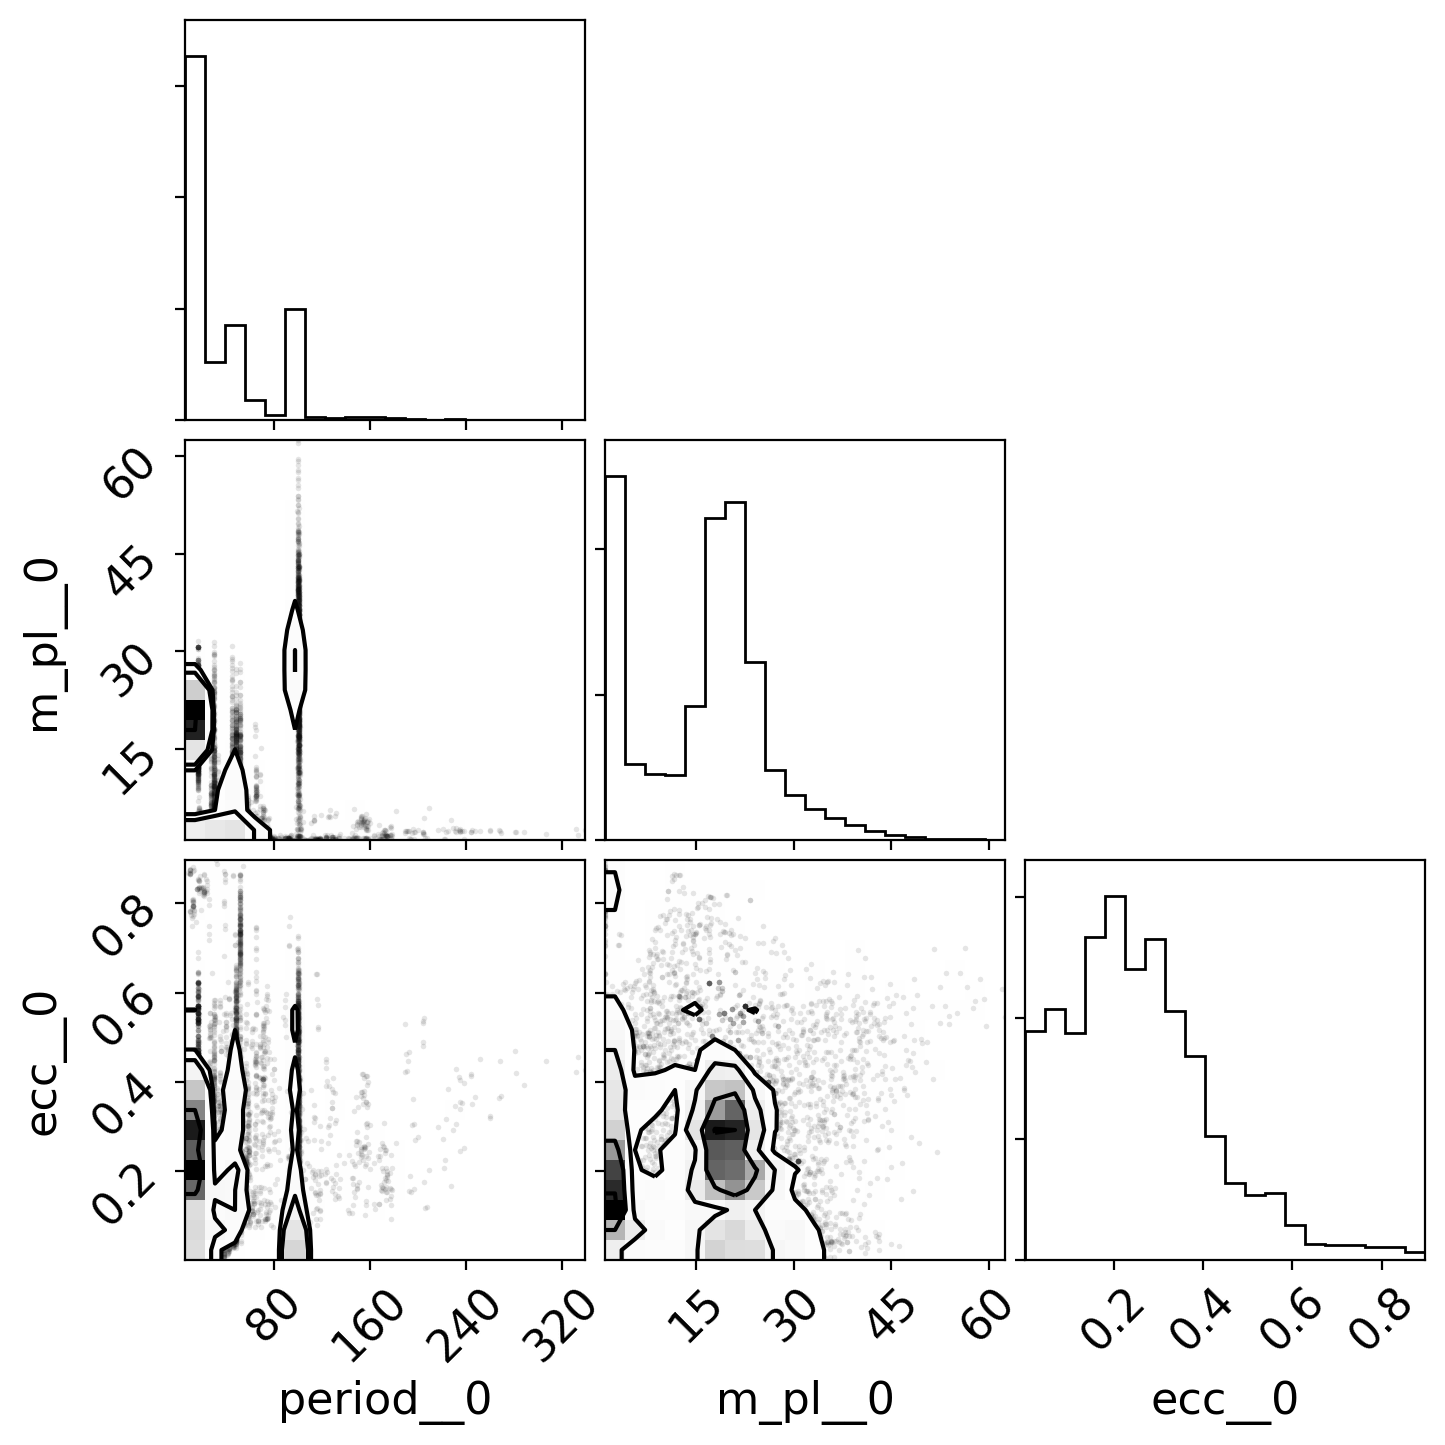

In [46]:
varnames = ["period", "m_pl", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

In [47]:
p = map_soln["period"]
t0 = map_soln["t0"]
jit2_pre = np.exp(2*map_soln["logs_rv_pre"])
jit2_pug = np.exp(2*map_soln["logs_rv_pug"])

bkg = map_soln["bkg"]

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold[~pug], y_rv[~pug] - bkg[~pug], yerr=np.sqrt(yerr_rv[~pug]**2 + jit2_pre), fmt=",k", alpha=0.3)
plt.errorbar(x_fold[pug], y_rv[pug] - bkg[pug], yerr=np.sqrt(yerr_rv[pug]**2 + jit2_pug), fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")
#plt.scatter(x_fold[mask], y_rv[mask] - bkg[mask], c='r', s=30)


# Bin the data
bins = np.linspace(-0.5 * p, 0.5*p, 7).flatten()
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_rv**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_rv**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Plot the model prediction
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
plt.plot(t_fold[inds], map_soln['vrad_pred'][inds], color="C1", label="model")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]");

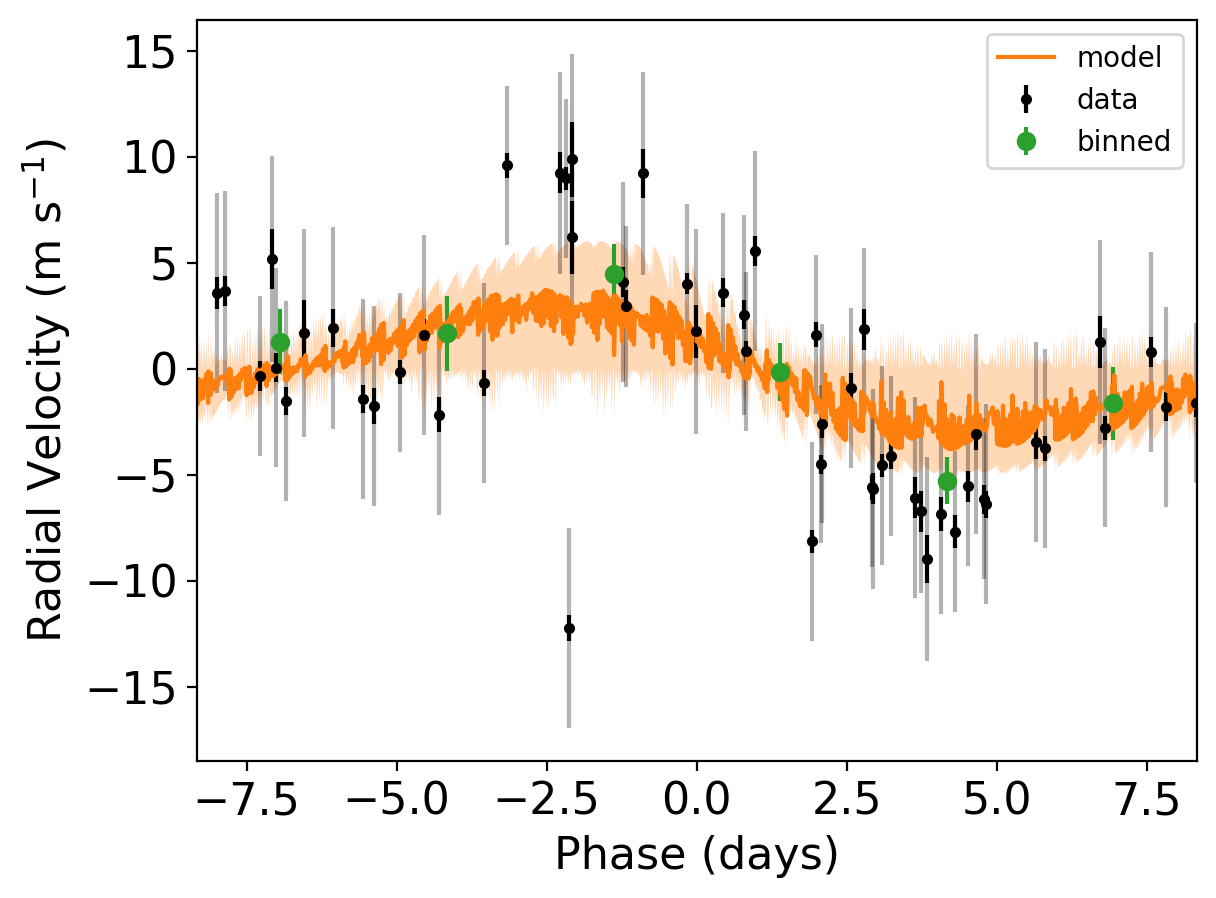

In [48]:
# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])
jit2_pre = np.exp(2*np.median(trace["logs_rv_pre"]))
jit2_pug = np.exp(2*np.median(trace["logs_rv_pug"]))

yerr_corrected = np.copy(yerr_rv**2)
yerr_corrected[~pug] += jit2_pre
yerr_corrected[pug] += jit2_pug
yerr_corrected = np.sqrt(yerr_corrected)


bkg = np.median(trace["bkg"], axis=0)

# Plot the folded data
x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_corrected, fmt=",k", alpha=0.3)
plt.errorbar(x_fold, y_rv - bkg, yerr=yerr_rv, fmt=".k", label="data")

bins = np.linspace(-0.5 * p, 0.5*p, 7)
num, _ = np.histogram(x_fold, bins, weights=(y_rv - bkg) / yerr_corrected**2)
denom, _ = np.histogram(x_fold, bins, weights=1 / yerr_corrected**2)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("Phase (days)")
plt.ylabel("Radial Velocity (m s$^{-1}$)")
plt.tight_layout();

In [47]:
map_soln['ecc']

array([0.23306937])

#### Constrain eccentricity from tidal circularization?

In [48]:
from astropy.constants import G

m_env_factor = 0.005 # fraction of mass in convective zone - I'm making this up!!
# also making up stellar luminosity in the below eqn
primary_factor = ((1. * u.Lsun) / (m_env_factor * mass_radius_mu[0] * u.Msun * (mass_radius_mu[1] * u.Rsun)**2)).decompose()
q = (10 * u.Mearth / (mass_radius_mu[0] * u.Msun)).decompose()
a = (((17. * u.day)**2 * G * mass_radius_mu[0] * u.Msun / (4. * np.pi**2))**(1/3)).decompose()
dist_factor = (mass_radius_mu[1] * u.Rsun / a).decompose()
t_circ = 1./(1 * primary_factor**(1/3) * m_env_factor * q * (1. + q) * dist_factor**8)

In [50]:
a.to(u.AU)

<Quantity 0.12862599 AU>

In [49]:
t_circ.to(u.yr)

<Quantity 2.25688319e+17 yr>

Seems like we can't set any real bounds on the eccentricity, so we're forced to leave it as a free parameter.

#### Two planets?

##### build a periodogram from the residuals:

peaks at:
1.04 days
120.07 days
1.04 days
1.01 days
1.06 days
1.01 days
121.09 days
1.01 days
1.06 days
1.01 days
25.18 days
25.23 days
1.06 days
1.01 days
1.06 days


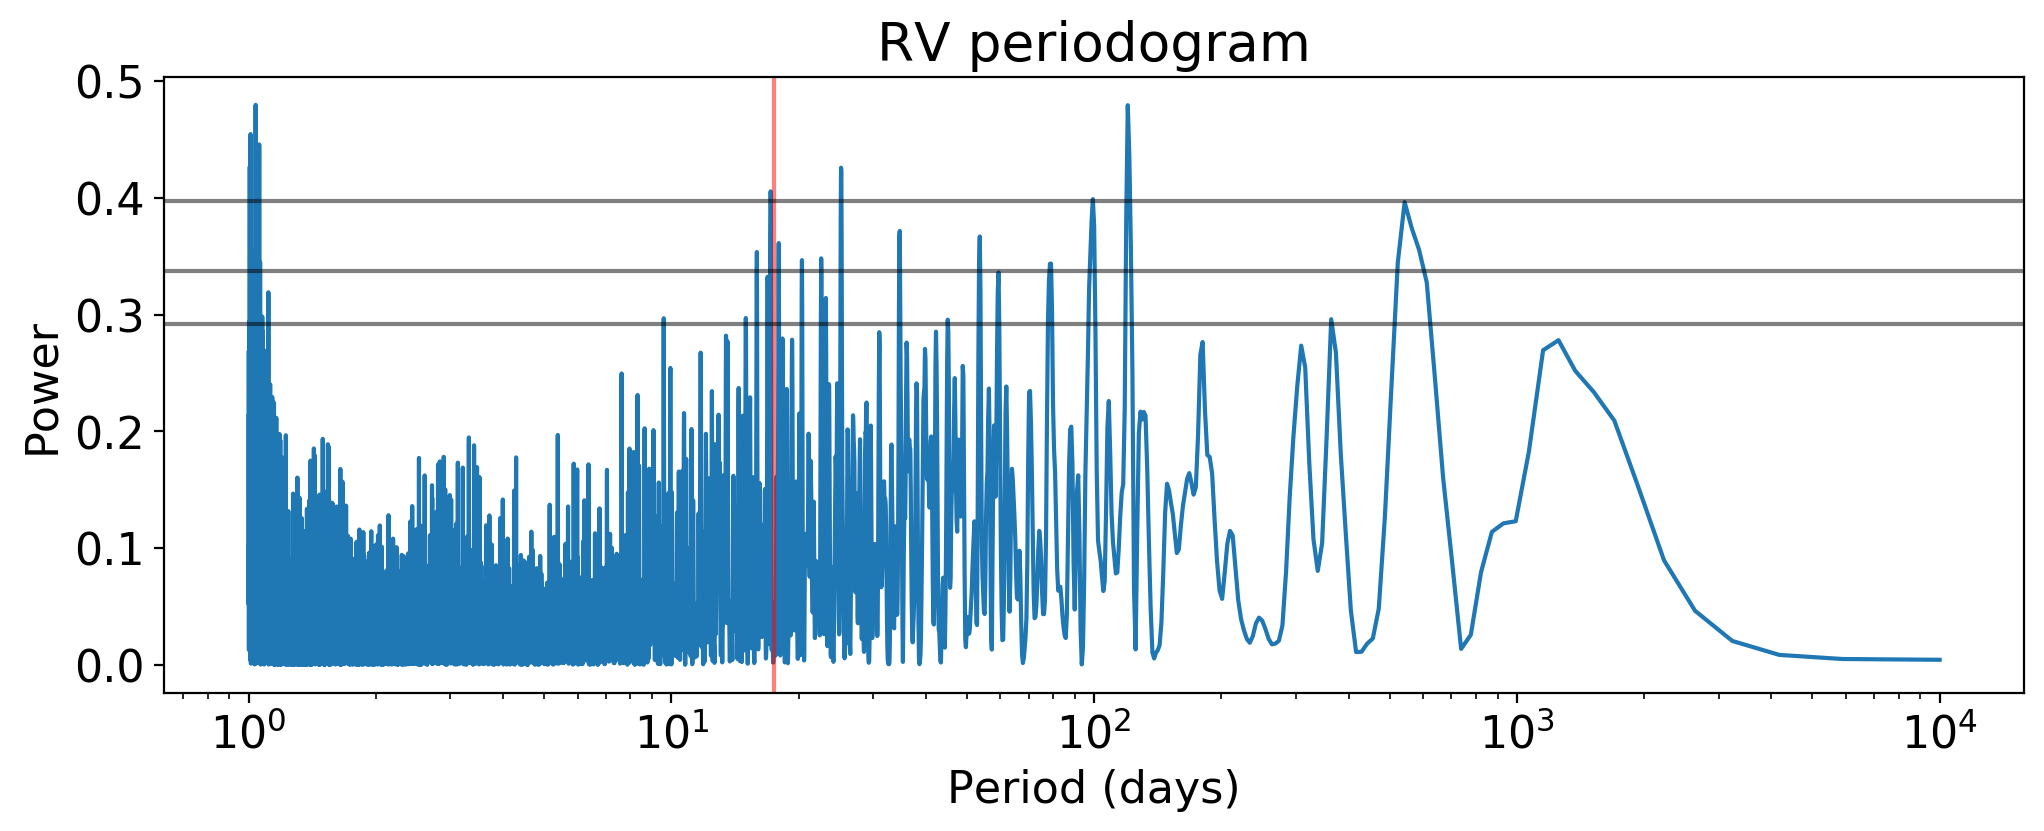

In [66]:
resids = y_rv - map_soln['rv_model']

freq, power = LombScargle(x_rv, resids, yerr_rv).autopower(minimum_frequency=1.e-4,
                                                   maximum_frequency=1.)
probabilities = [0.05, 0.01, 0.001]
fal = ls.false_alarm_level(probabilities) 

fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(1./freq, power)
ax.axvline(periods, c='r', alpha=0.5)
for f in fal:
    ax.axhline(f, c='k', alpha=0.5)
ax.set_xscale('log')
ax.set_title('RV periodogram')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Power')
print("peaks at:")
sorted_peaks = 1./freq[np.argsort(power)[::-1]]
for i in range(15):
    print("{0:.2f} days".format(sorted_peaks[i]))

In [ ]:
trace['vrad']

#### build a 2-D periodogram:

In [72]:
xs = x_rv
ys = y_rv
ivars = 1./yerr_rv**2

def design_matrix(P1, P2):
    A = np.zeros((len(xs),9))
    A[:,0] = xs**2
    A[:,1] = xs
    A[:,2] = np.invert(pug).astype(int)
    A[:,3] = pug.astype(int)
    A[:,4] = fwhm_rv
    A[:,5] = np.sin(2*np.pi / P1 * xs)
    A[:,6] = np.cos(2*np.pi / P1 * xs)
    A[:,7] = np.sin(2*np.pi / P2 * xs)
    A[:,8] = np.cos(2*np.pi / P2 * xs)
    return A

def loglike(A, param):
    resids = ys - np.dot(A,param)
    return -0.5 * np.sum(resids**2 * ivars)

def best_param(A, cov=True):
    # returns the optimized parameters for a given design matrix A
    # if cov, return a tuple (best_param, cov)
    ATA = np.dot(A.T, ivars[:, None] * A)
    ATy = np.dot(A.T, ivars * ys)
    soln = np.linalg.solve(ATA, ATy)
    if cov:
        return soln, cov
    return soln

N = 2000
#ps = np.logspace(0,2.0,num=N) # period grid
ps = np.linspace(1,200,num=N)
loglikes = np.zeros((N,N)) + np.nan
solns = np.zeros((N,N,9))
for i,p1 in tqdm.tqdm(enumerate(ps)):
    for j,p2 in enumerate(ps):
        if p2 <= p1:
            continue
        else:
            A = design_matrix(p1,p2)
            soln, cov = best_param(A)
            solns[i,j,:] = soln
            loglikes[i,j] = loglike(A, soln)

2000it [01:33, 21.32it/s] 


In [87]:
i = np.argsort(np.abs(ps - 17.47))[0]
ps[i]

17.425712856428213

15.93 days
34.55 days
17.13 days
45.00 days
119.36 days
119.46 days
119.27 days
119.56 days
119.17 days
119.66 days


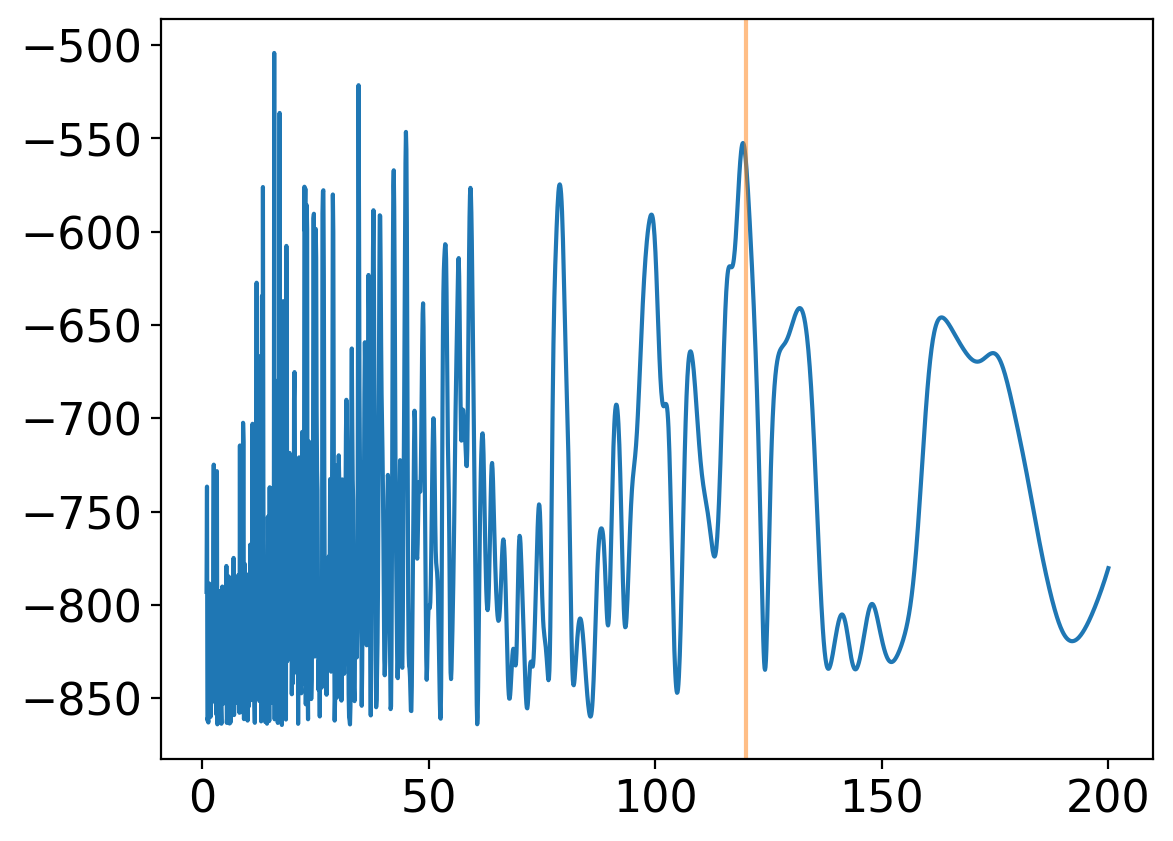

In [110]:
all_lnlikes = np.nanmedian(np.vstack((loglikes[i,:], loglikes[:,i])), axis=0)
plt.plot(ps, all_lnlikes)
sorted_peaks = ps[np.argsort(all_lnlikes)[::-1]]
plt.axvline(120., c='C1', alpha=0.5)
for j in range(1,11): # skip first one b/c it's a nan at i
    print("{0:.2f} days".format(sorted_peaks[j]))

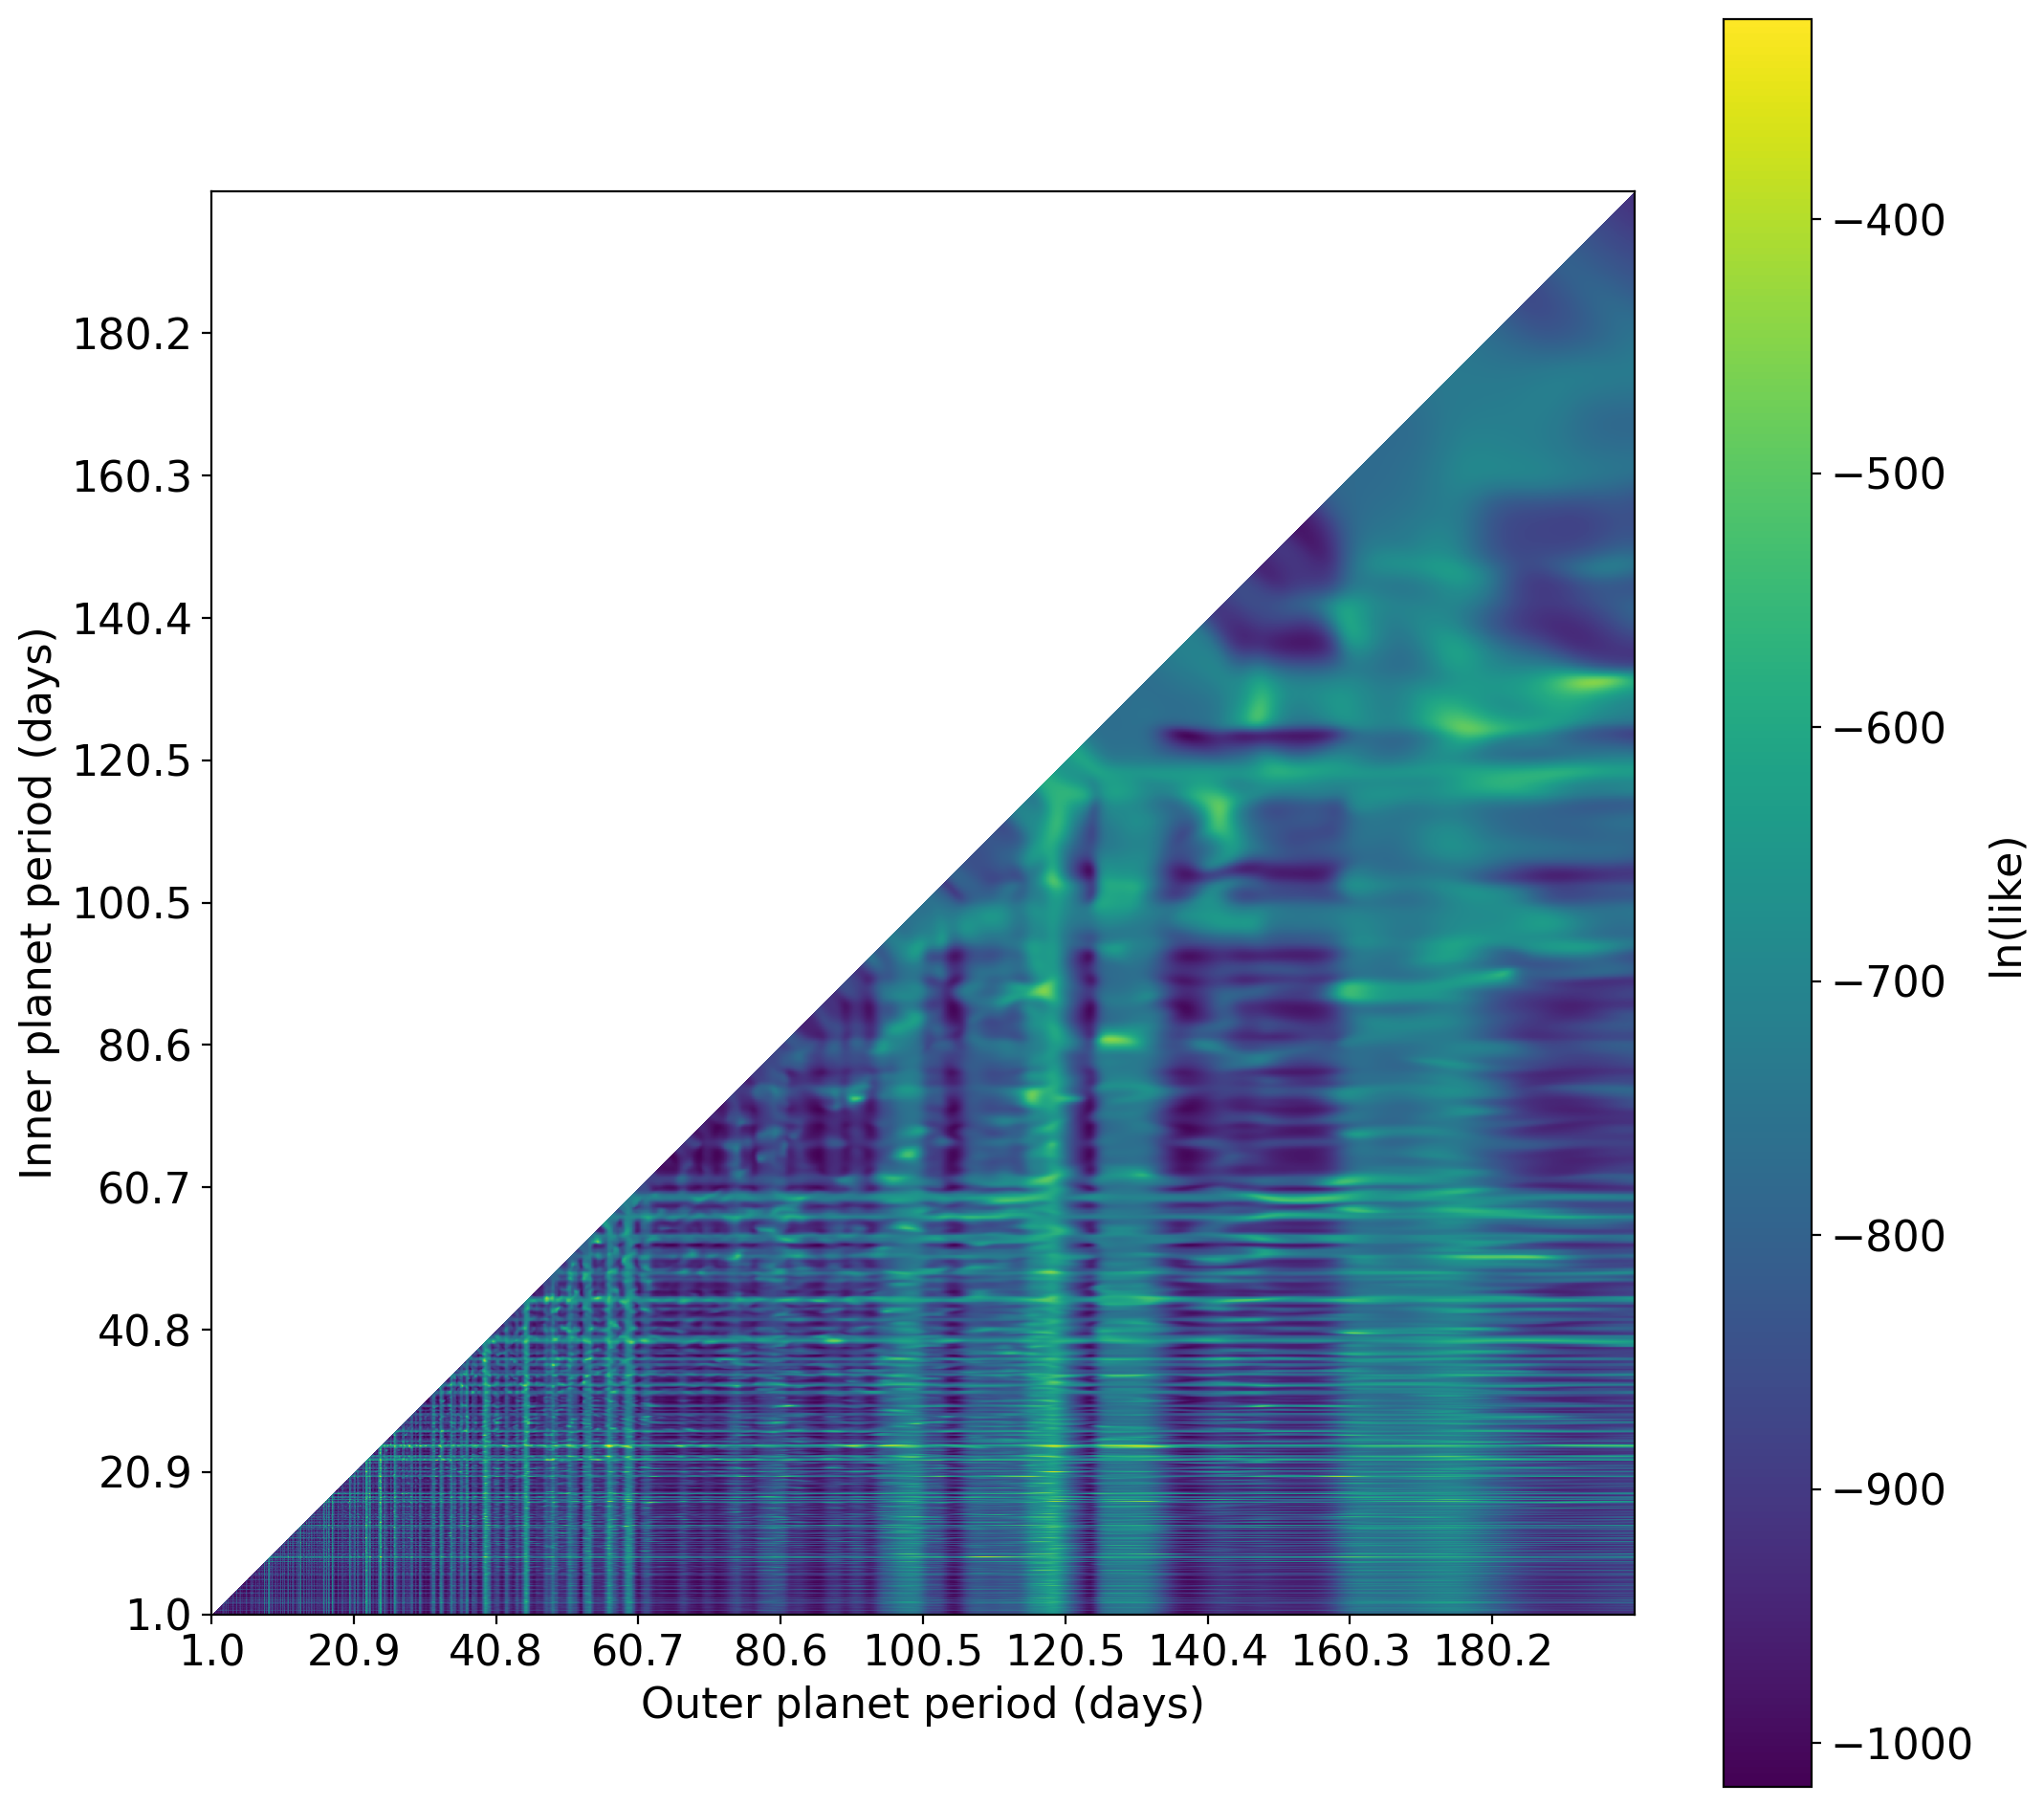

In [78]:
fig,ax = plt.subplots(figsize=(12,12))
im = ax.imshow(loglikes, origin='lower')
tick_inds = np.arange(0,2000,200)
tick_labels = ['{0:.1f}'.format(t) for t in ps[tick_inds]]
ax.set_yticks(tick_inds)
ax.set_yticklabels(tick_labels)
ax.set_xticks(tick_inds)
ax.set_xticklabels(tick_labels)
ax.set_xlabel('Outer planet period (days)')
ax.set_ylabel('Inner planet period (days)')
cb = fig.colorbar(im)
cb.set_label('ln(like)');